In [1]:
%matplotlib inline

In [2]:
import os
from astropy.io import fits as py
import numpy as np
import matplotlib.pyplot as plt

#from scipy.interpolate import interp1d

plt.rcParams['figure.figsize'] = (20, 8)
plt.rcParams['font.size'] = 25

In [3]:
def Normalization(data_x, data_y, bins, p_order, fraction, plot, section=0):
    # Input Parameters
    sbin = bins   # of bins used'
    nord = p_order    # order of the curve fitting (>6 is spline)
    frac = fraction # the upper fraction points defined as cont
    #plot = True # plot keyword (1 on, 2 more info,0 off)
    mask = []   # indicies of points to use (or used) in fit'
    bot  = False  # if set then bottom of spectrum is fit
    edit = True   # manuel editing by point (1 on, 0 off)
    temr = 'none' # selects terminal version of point'
    fill_value = 12500.0 # in case of a spline
    
    c = data_x
    s = data_y
    
    
    # Set Parameters
    Len = len(s)
    st = 0
    w = range(Len)
    if plot :
        plt.figure()
        ss = s
        if len(mask) > 0:
            ss = np.ones_like(s)*3*np.max(s)
            ss[mask] = s[mask]
        plt.plot(w, ss)
    mbin = [[] for i in range(sbin)]
    mbw  = [[] for i in range(sbin)]
    mid = 1    # affects how FRAC is interpreted(originally 2)
    
    #Mask out portions of spectrum, if a valid mask was passed or constructed.
    if len(mask) > 1:     # true: valid mask exists
        wsec = w[mask]    # wavelengths of valid continuum points
        ssec = s[mask]    # valid continuum points
    else:
        wsec = w
        ssec = s
        
    Len = len(ssec)
    lb  = Len/sbin


    #***find continuum in each bin
    st = 0
    bpt = lb*(1. - frac/mid)  #is a number
    if bot: bpt=lb*frac/mid
    for nbin in range(sbin):
        nd  = st +lb -1
        wb  = np.array(wsec[int(st):int(nd)])
        Bin = np.array(ssec[int(st):int(nd)])
        Sorted = np.argsort(Bin)  # sort data 
        cnt = Bin[Sorted[int(bpt):].astype(int)]
        cnw = wb[Sorted[int(bpt):].astype(int)]
        st  = nd + 1
        mbin[nbin] = cnt
        mbw[nbin]  = cnw
        if plot:  # remove or comment if the date is too big
            plt.plot(wb, Bin)
            plt.plot(cnw, cnt, '.k')
            
    temp_x = []
    temp_y = []
    for i in range(len(mbw)):
        temp_x.extend(mbw[i])
        temp_y.extend(mbin[i])

    temp_x = np.array(temp_x)
    temp_y = np.array(temp_y)
    mbin  = [x for _, x in sorted(zip(temp_x, temp_y))]
    mbw = sorted(temp_x)

    if plot:
        plt.figure()
        plt.plot(mbw, mbin, 'ko')
        
    #***polynomial or spline fit to continuum
    npl = nord 
    x = mbw 
    y = mbin
    if nord <= 6:
        if nord >= sbin: npl = sbin-1
        nx = len(x)
        mn = np.sum(x)/nx
        x  = x - mn   
        wf = w-mn
        #mn = mean(x)   &   x=x - mn   &   wf=float(w-mn)
        cf = np.polyfit(x,y,npl)     #call poly_fit(intrinsic)
        # be carefull, it returns coeficient in the oposite order.
        c  = np.polyval(cf, wf)      #call poly
        print(cf)
    else:
        wf = w
        print(np.min(x), np.max(x))
        print(np.min(wf), np.max(wf))
        f_interp = interp1d(x, y, bounds_error=False, fill_value=fill_value)
        c = f_interp(wf)
        
    #Plot
    if plot:
        plt.figure()
        plt.plot(w, c, 'k', lw=3)
        plt.plot(w, s, 'C0-')
        plt.plot(mbw,mbin, 'r', alpha=0.5)
        plt.figure()
        plt.plot(w, c, 'k', lw=3)
        plt.plot(mbw,mbin, 'r.', alpha = 0.5)
        plt.figure()
        plt.plot(w, s/c, 'k.')
        plt.plot(w, np.ones(len(w)), '--r', lw=2)
        plt.ylim(0.0,1.2)
    #plt.plot(data_x, s/c, ',')
    #plt.plot(data_x, np.ones(len(w)), '--r', lw=2)
    #plt.text(data_x[0], 0.8, str(section))
    plt.ylim(0.5,1.2)
    return data_x, s/c

In [4]:
# Read the files
path = '/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/'

In [5]:
frame_spec = []
frame_error_spec = []
frame_WL = []

for i in range(100):
    print         (path + str(i+100) + "/cr2res_obs_staring_extracted.fits")
    fits = py.open(path + str(i+100) + "/cr2res_obs_staring_extracted.fits")
    raw_data1 = fits[1].data
    raw_data2 = fits[2].data
    raw_data3 = fits[3].data
    
    spec       = [[] for i in range(21)]
    error_spec = [[] for i in range(21)]
    WL         = [[] for i in range(21)]
    
    for a in range(2048):
        for b in range(6):
            spec[b].        append(raw_data1[a][b*3])
            error_spec[b].  append(raw_data1[a][b*3+1])
            WL[b].          append(raw_data1[a][b*3+2])
        for b in range(6):
            spec[b+6].      append(raw_data2[a][b*3])
            error_spec[b+6].append(raw_data2[a][b*3+1])
            WL[b+6].        append(raw_data2[a][b*3+2])
        for b in range(6):
            try:
                spec[b+12]. append(raw_data3[a][b*3])
            except: break
            error_spec[b+6].append(raw_data3[a][b*3+1])
            WL[b+12].       append(raw_data3[a][b*3+2])
            
    frame_spec.append(spec)
    frame_error_spec.append(error_spec)
    frame_WL.append(WL)

/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/100/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/101/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/102/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/103/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/104/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/105/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/106/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/107/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/108/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/109/cr2res_obs_staring_extracted.fits
/Users/ricardoramire

/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/184/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/185/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/186/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/187/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/188/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/189/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/190/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/191/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/192/cr2res_obs_staring_extracted.fits
/Users/ricardoramirez/reflex_data/PersonalReduction/Reduce1/193/cr2res_obs_staring_extracted.fits
/Users/ricardoramire

Text(0, 0.5, 'ADU')

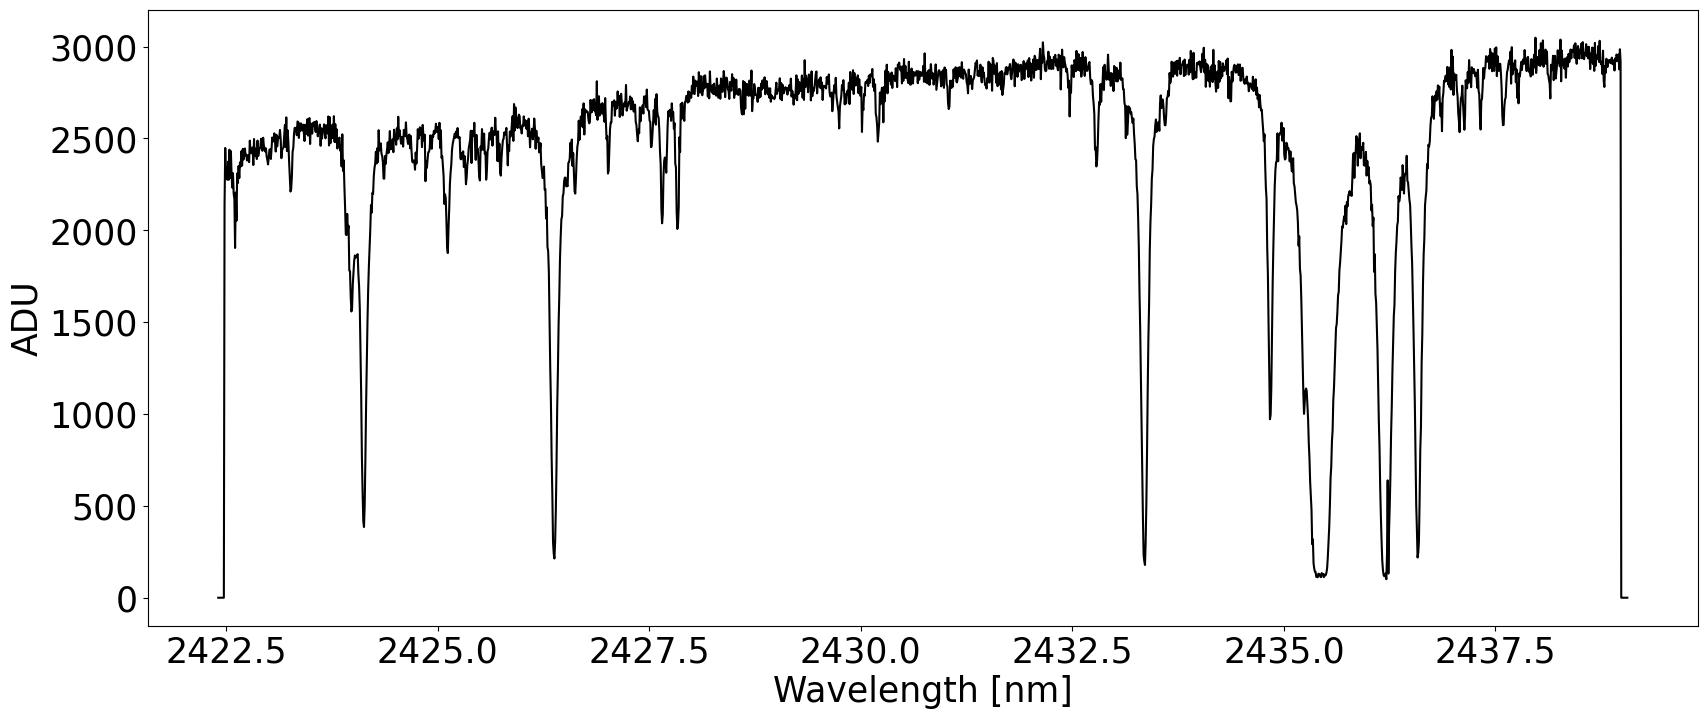

In [6]:
Frame = 0
#spec = frame_spec[Frame]
#WL = frame_error_spec[Frame]

n = 0
plt.plot(WL[n], spec[n], 'k')
plt.xlabel(r'Wavelength [nm]')
plt.ylabel(r'ADU')

Text(0, 0.5, 'ADU')

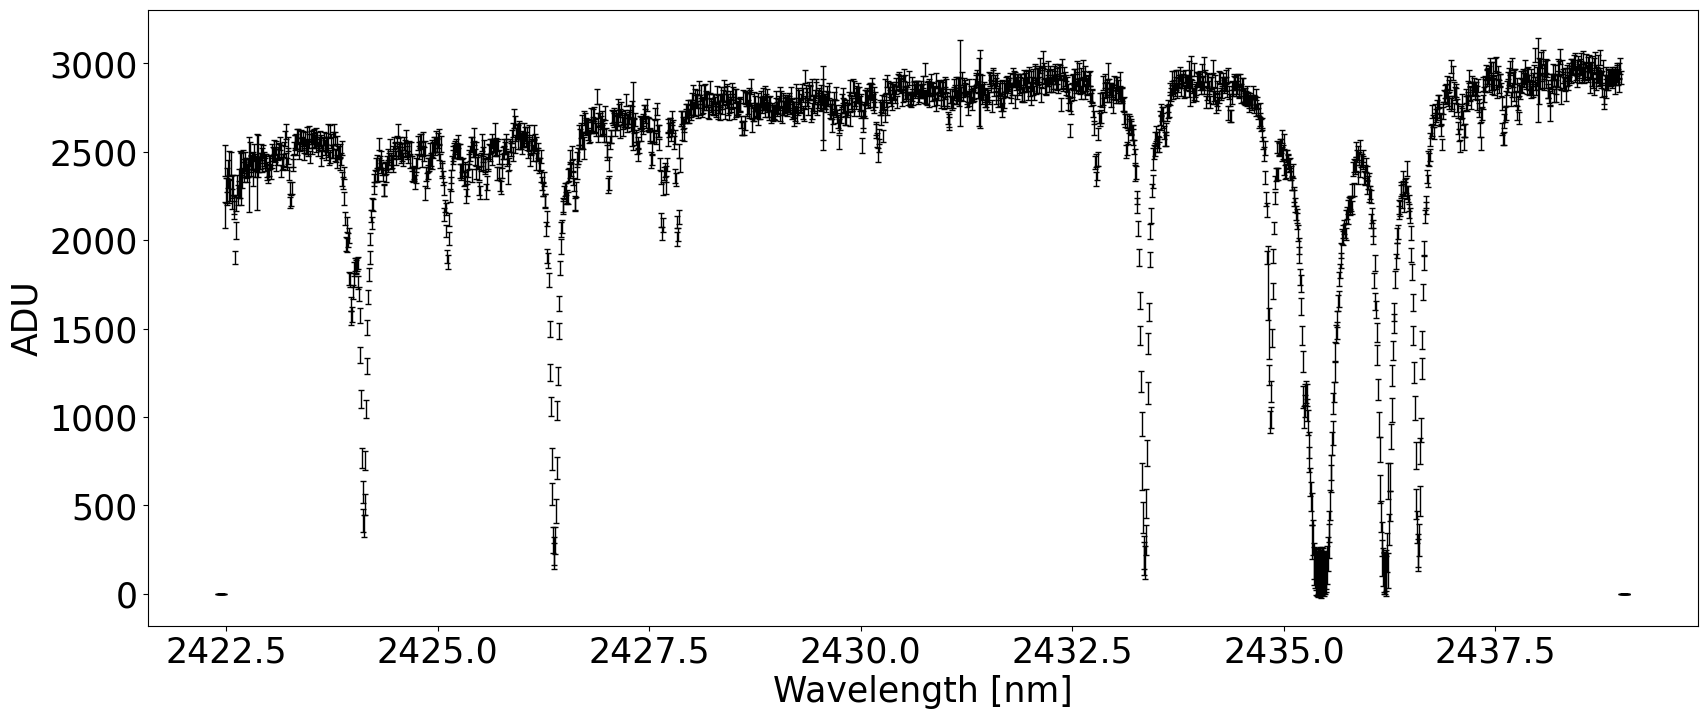

In [7]:
n = 0
plt.errorbar(WL[n], spec[n], yerr=error_spec[n], color ='k', fmt=',', capsize=2 , markersize=1, elinewidth=1)
#plt.ylim(2000,11000)
#plt.xlim(2382, 2384)
plt.xlabel(r'Wavelength [nm]')
plt.ylabel(r'ADU')

(-100.0, 4000.0)

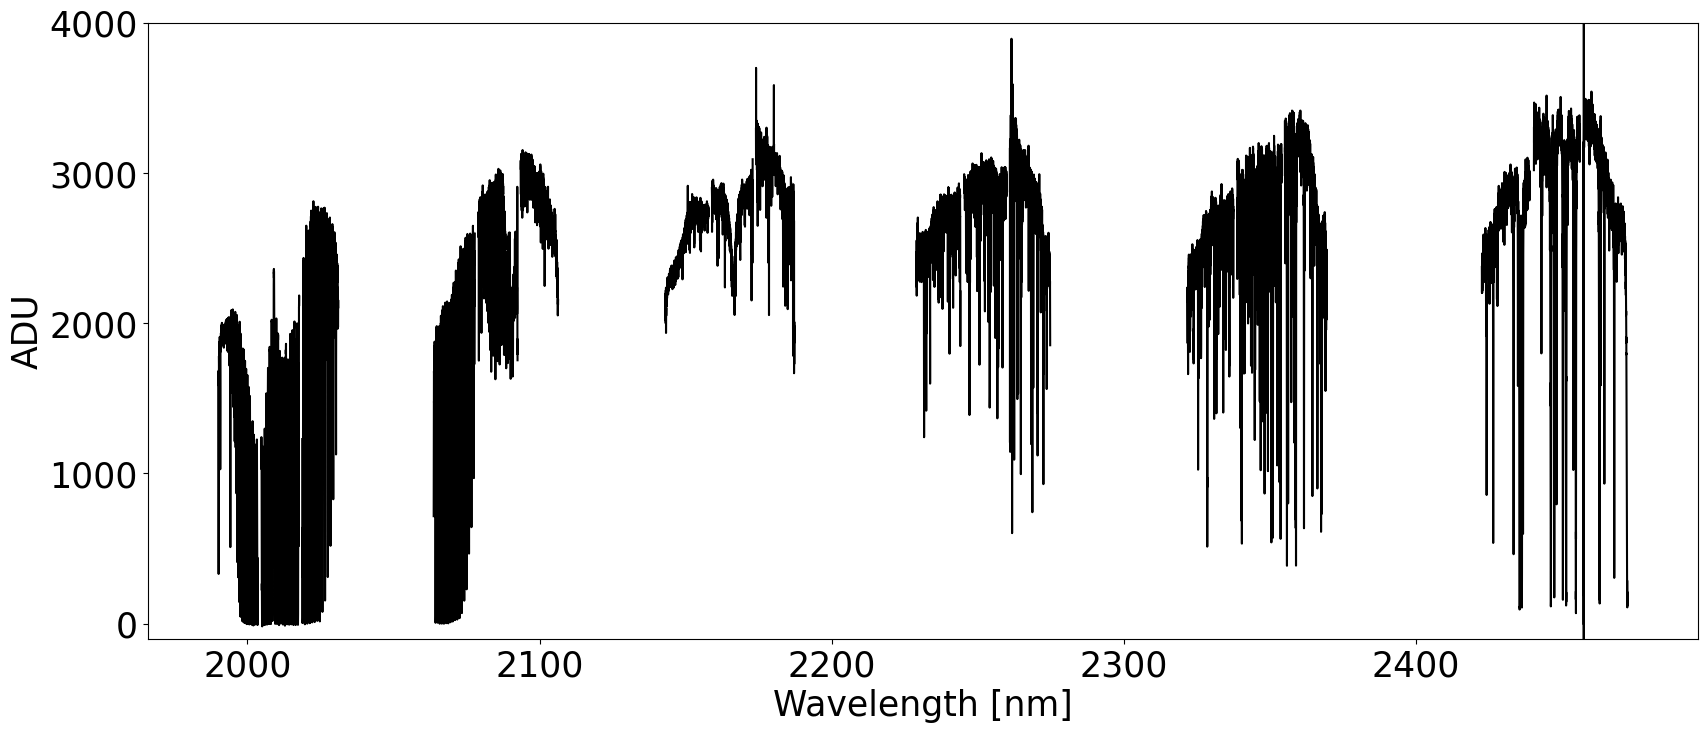

In [8]:
frame = 0
for i in range(21):
    #plt.plot(frame_WL[frame][i], frame_spec[frame][i], 'C'+str(frame))
    plt.plot(frame_WL[frame][i][10:-12], frame_spec[frame][i][10:-12], 'k')
plt.xlabel(r'Wavelength [nm]')
plt.ylabel(r'ADU')
plt.ylim(-100, 4000)

(-100.0, 4000.0)

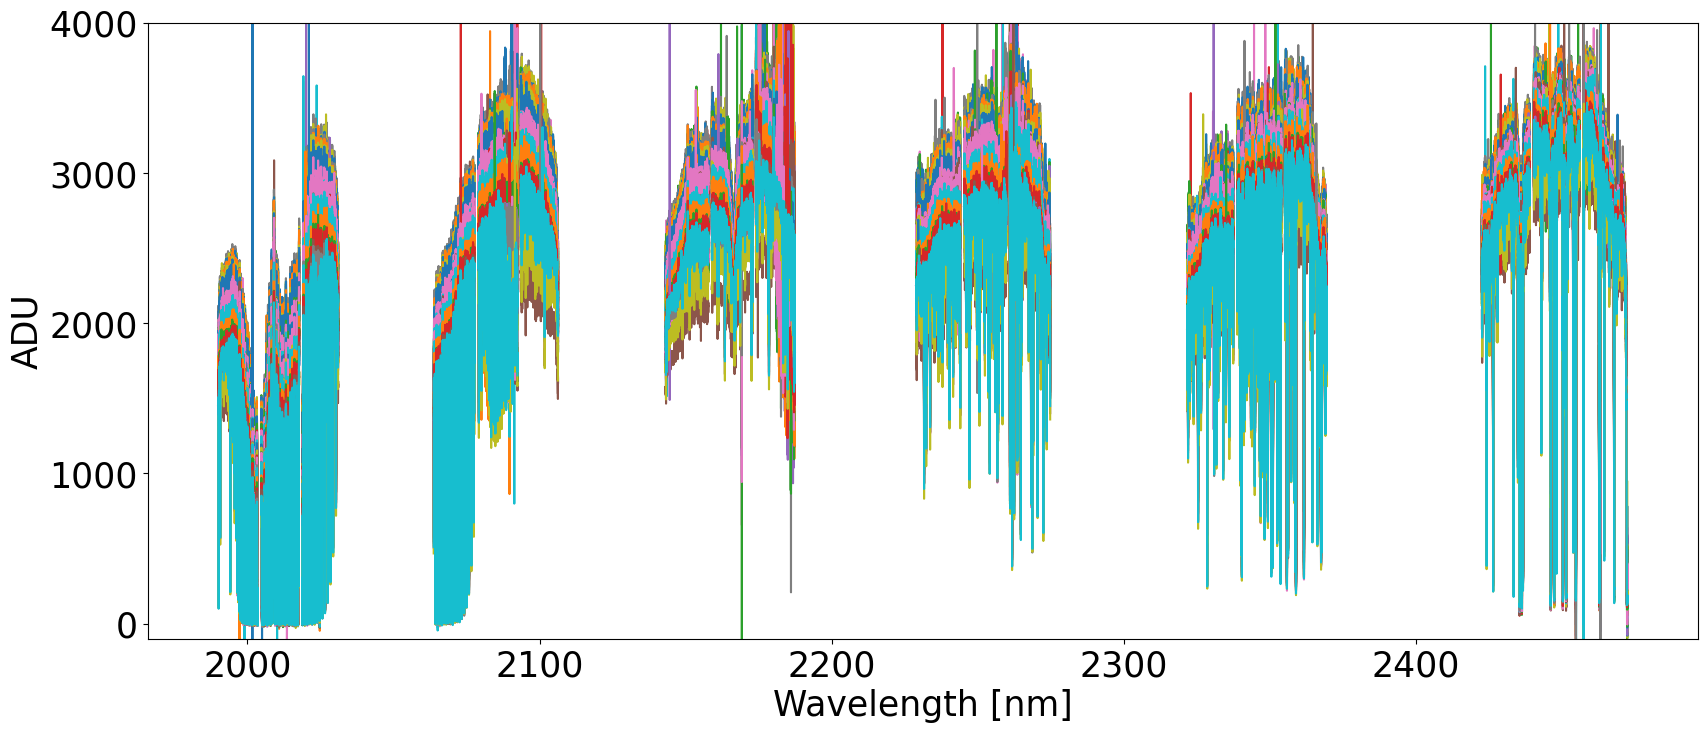

In [9]:
for frame in range(100):
    for i in range(21):
        plt.plot(frame_WL[frame][i][10:-12], frame_spec[frame][i][10:-12], 'C'+str(frame))
plt.xlabel(r'Wavelength [nm]')
plt.ylabel(r'ADU')
plt.ylim(-100, 4000)

(-100.0, 4000.0)

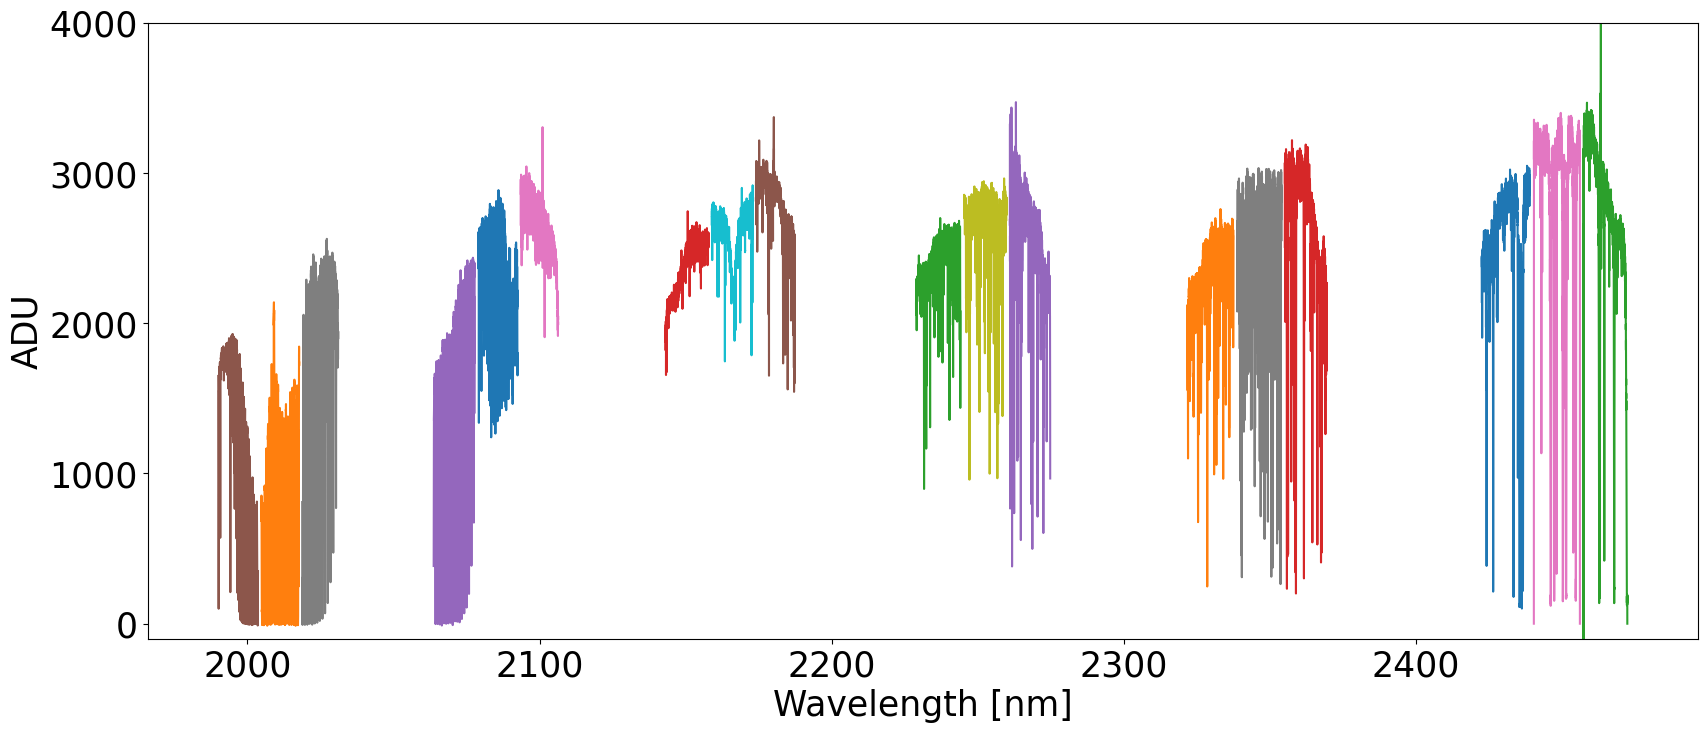

In [10]:
for i in range(21):
    plt.plot(frame_WL[frame][i][9:-10], frame_spec[frame][i][9:-10])
plt.xlabel(r'Wavelength [nm]')
plt.ylabel(r'ADU')
plt.ylim(-100, 4000)

(2.339, 2.353)

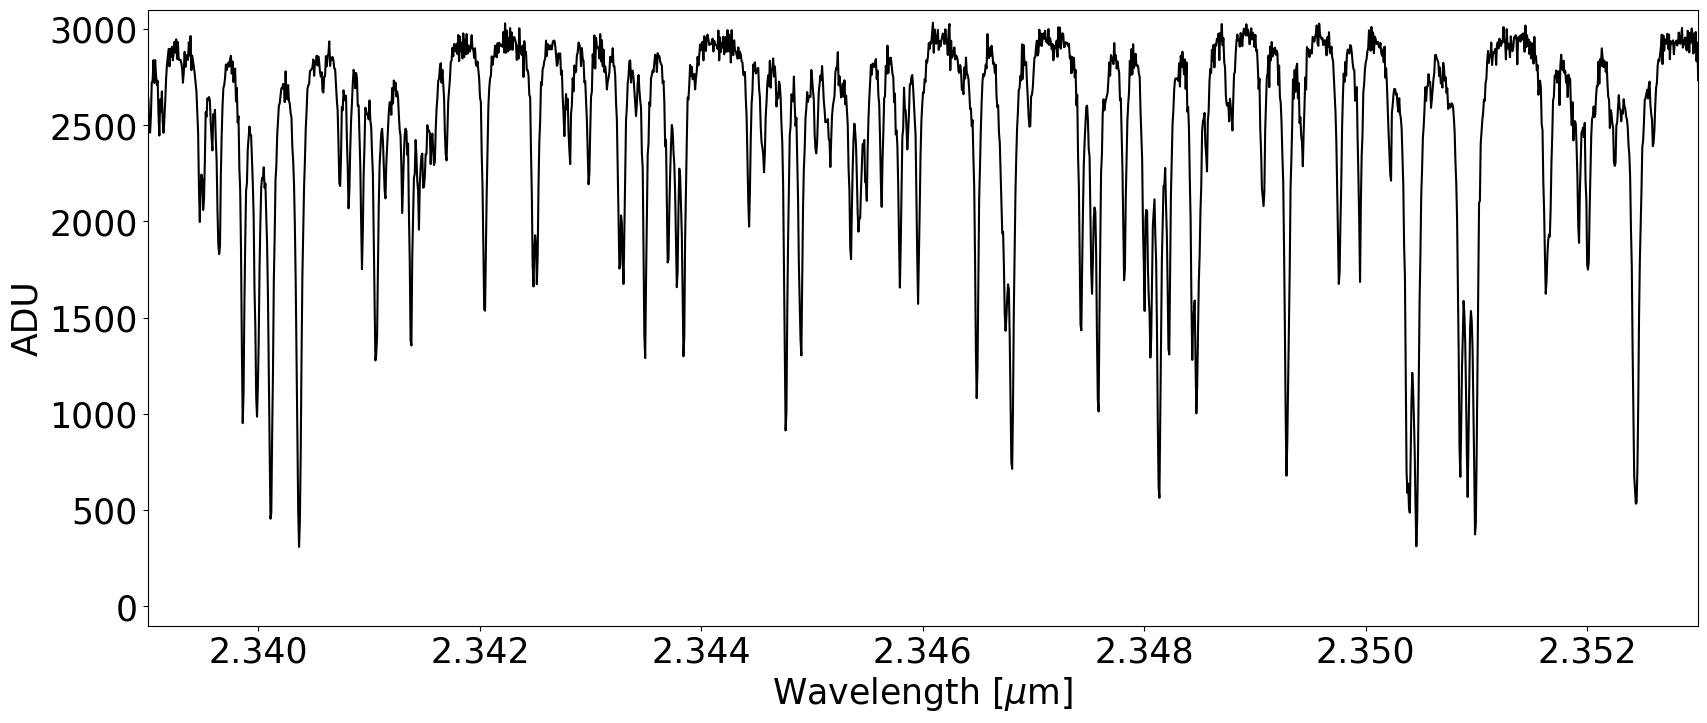

In [11]:
for i in range(21):
    #plt.figure()
    plt.plot(np.array(frame_WL[frame][i][10:-12])/1000, frame_spec[frame][i][10:-12], 'k')
plt.xlabel(r'Wavelength [$\mu$m]')
plt.ylabel(r'ADU')
plt.ylim(-100, 3100)
plt.xlim(2.339, 2.353)

(2.441, 2.456)

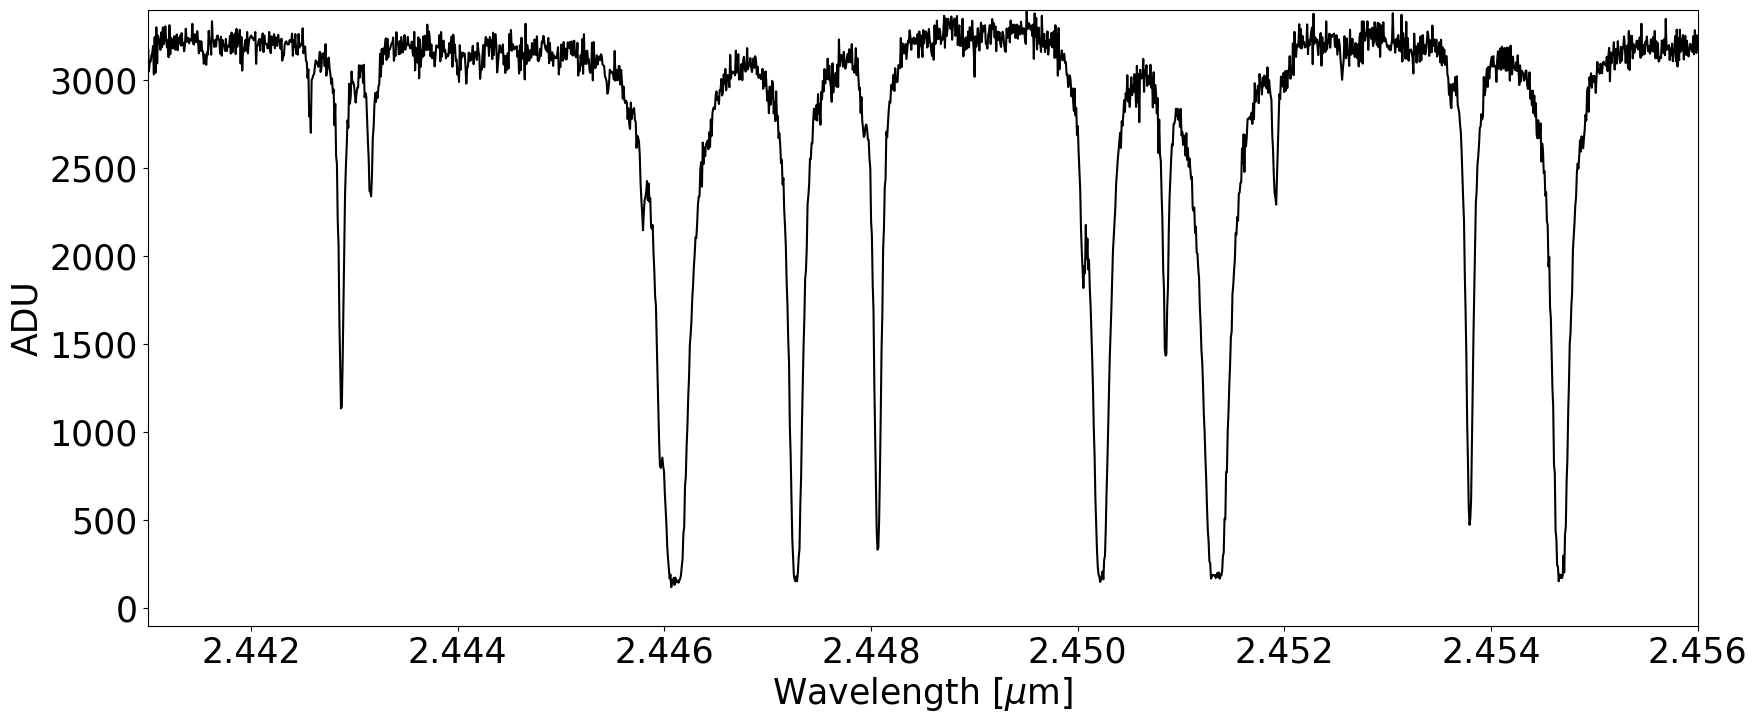

In [12]:
for i in range(21):
    #plt.figure()
    plt.plot(np.array(frame_WL[frame][i][10:-12])/1000, frame_spec[frame][i][10:-12], 'k')
plt.xlabel(r'Wavelength [$\mu$m]')
plt.ylabel(r'ADU')
plt.ylim(-100, 3400)
plt.xlim(2.441, 2.456)

Text(0, 0.5, 'ADU')

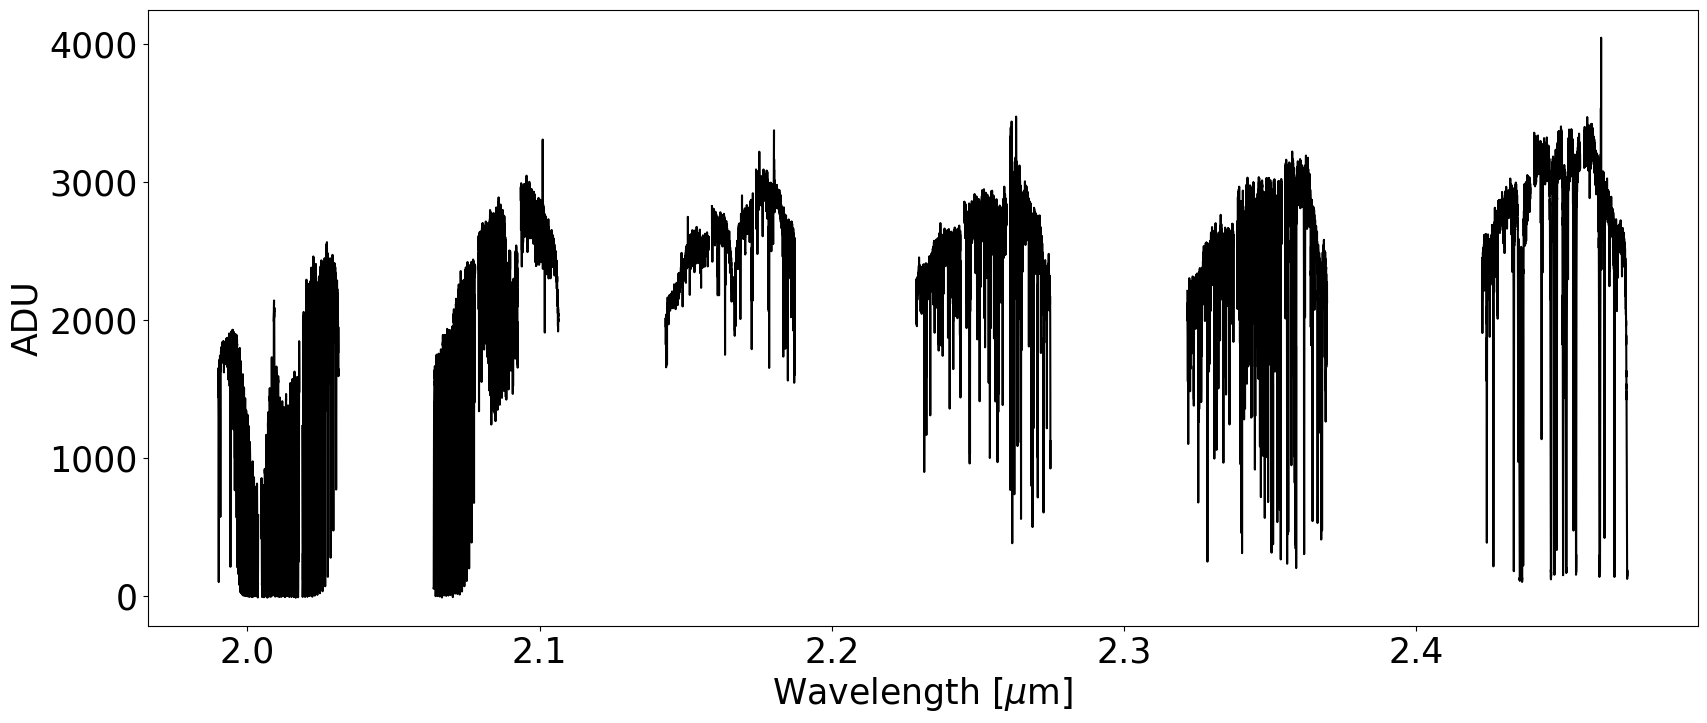

In [13]:
i = 5
plt.plot(np.array(frame_WL[frame][i][4:-4])/1000, frame_spec[frame][i][4:-4], 'k')
i = 11
plt.plot(np.array(frame_WL[frame][i][4:-4])/1000, frame_spec[frame][i][4:-4], 'k')
i = 17
plt.plot(np.array(frame_WL[frame][i][3:-4])/1000, frame_spec[frame][i][3:-4], 'k')

i = 4
plt.plot(np.array(frame_WL[frame][i][4:-4])/1000, frame_spec[frame][i][4:-4], 'k')
i = 10
plt.plot(np.array(frame_WL[frame][i][4:-5])/1000, frame_spec[frame][i][4:-5], 'k')
i = 16
plt.plot(np.array(frame_WL[frame][i][5:-5])/1000, frame_spec[frame][i][5:-5], 'k')

i = 3
plt.plot(np.array(frame_WL[frame][i][5:-5])/1000, frame_spec[frame][i][5:-5], 'k')
i = 9
plt.plot(np.array(frame_WL[frame][i][6:-6])/1000, frame_spec[frame][i][6:-6], 'k')
i = 15
plt.plot(np.array(frame_WL[frame][i][6:-6])/1000, frame_spec[frame][i][6:-6], 'k')

i = 2
plt.plot(np.array(frame_WL[frame][i][7:-7])/1000, frame_spec[frame][i][7:-7], 'k')
i = 8
plt.plot(np.array(frame_WL[frame][i][6:-7])/1000, frame_spec[frame][i][6:-7], 'k')
i = 14
plt.plot(np.array(frame_WL[frame][i][8:-8])/1000, frame_spec[frame][i][8:-8], 'k')

i = 1
plt.plot(np.array(frame_WL[frame][i][7:-8])/1000, frame_spec[frame][i][7:-8], 'k')
i = 7
plt.plot(np.array(frame_WL[frame][i][8:-9])/1000, frame_spec[frame][i][8:-9], 'k')
i = 13
plt.plot(np.array(frame_WL[frame][i][9:-10])/1000, frame_spec[frame][i][9:-10], 'k')

i = 0
plt.plot(np.array(frame_WL[frame][i][9:-10])/1000, frame_spec[frame][i][9:-10], 'k')
i = 6
plt.plot(np.array(frame_WL[frame][i][10:-11])/1000, frame_spec[frame][i][10:-11], 'k')
i = 12
plt.plot(np.array(frame_WL[frame][i][22:-22])/1000, frame_spec[frame][i][22:-22], 'k')

plt.xlabel(r'Wavelength [$\mu$m]')
plt.ylabel(r'ADU')
#plt.ylim(-100, 3400)
#plt.xlim(2.441, 2.456)

In [14]:
full_wave_n = []
full_flux_n = []

Text(0, 0.5, 'ADU')

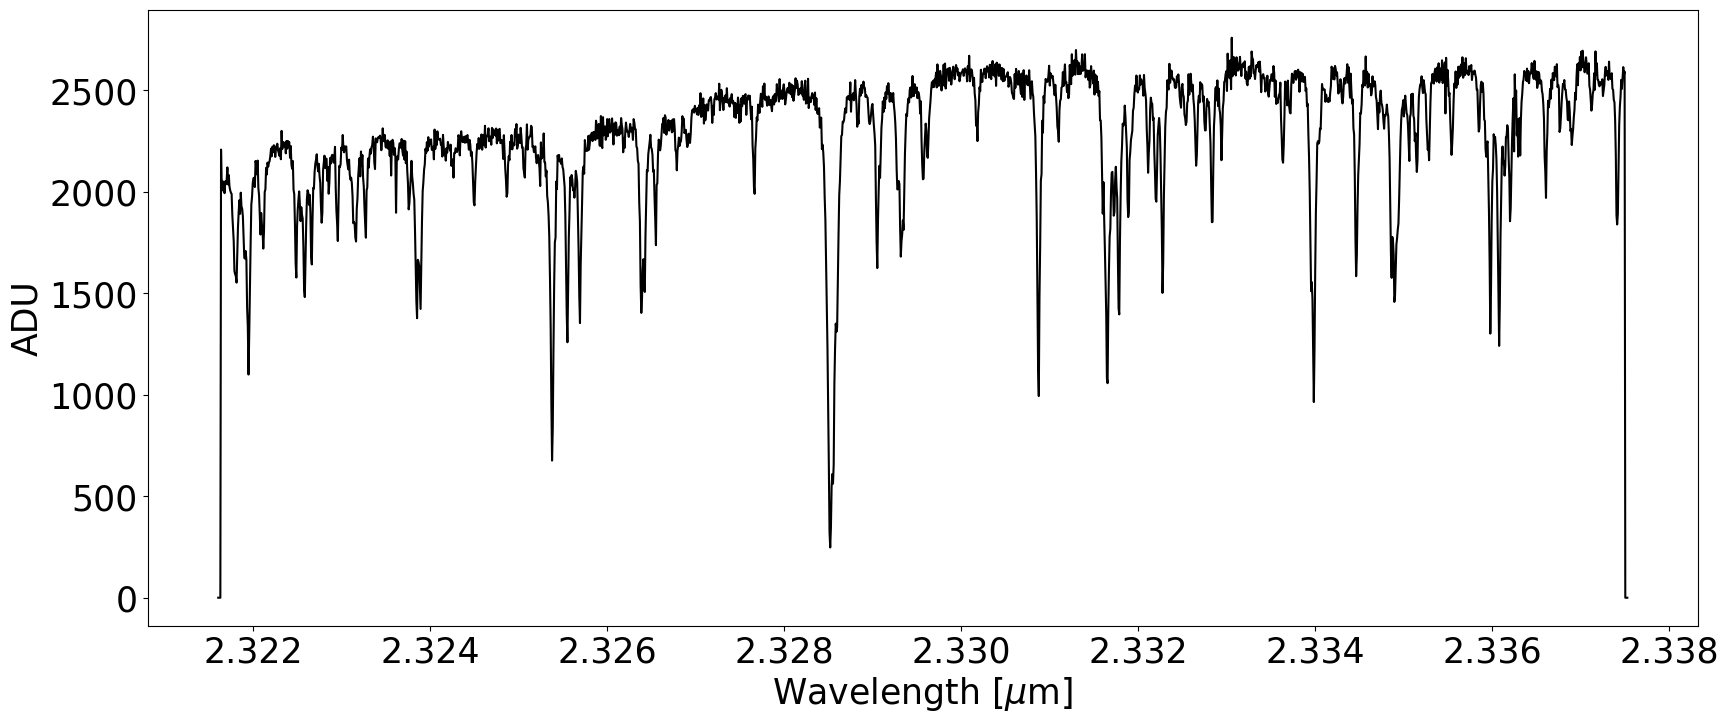

In [15]:
#test
i = 1
a = 3
b = -4
plt.plot(np.array(frame_WL[frame][i][a:b])/1000, frame_spec[frame][i][a:b], 'k')
plt.xlabel(r'Wavelength [$\mu$m]')
plt.ylabel(r'ADU')

# Testing Normalization part 1

6121


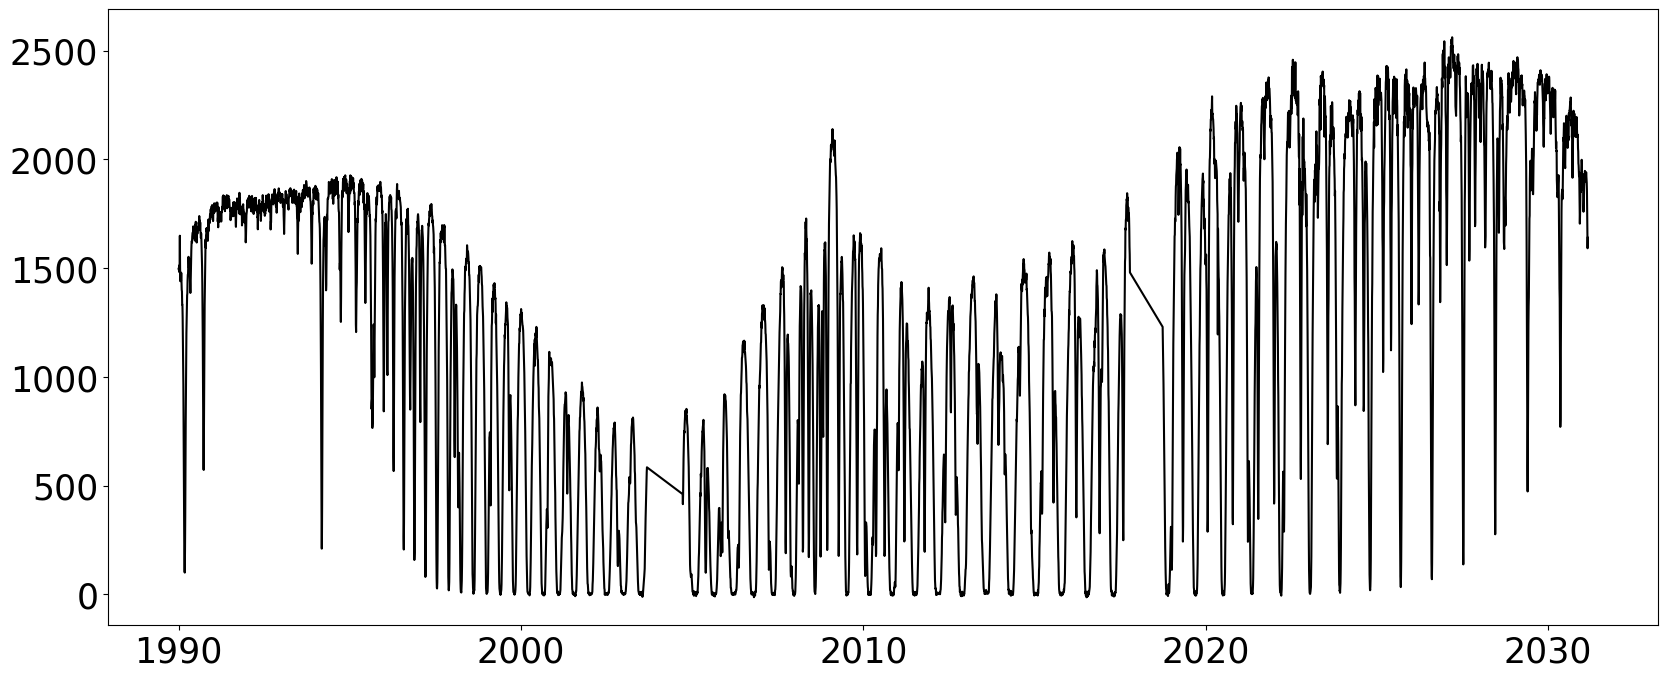

In [16]:
wave = []
flux = []

i = 5
wave.extend(frame_WL[frame][i][4:-4])
flux.extend(frame_spec[frame][i][4:-4])
i = 11
wave.extend(frame_WL[frame][i][4:-4])
flux.extend(frame_spec[frame][i][4:-4])
i = 17
wave.extend(frame_WL[frame][i][3:-4])
flux.extend(frame_spec[frame][i][3:-4])

print(len(wave))

wave = np.array(wave)
flux = np.array(flux)

plt.plot(wave,flux,'k')

[1.04252740e-01 2.08603892e+03]


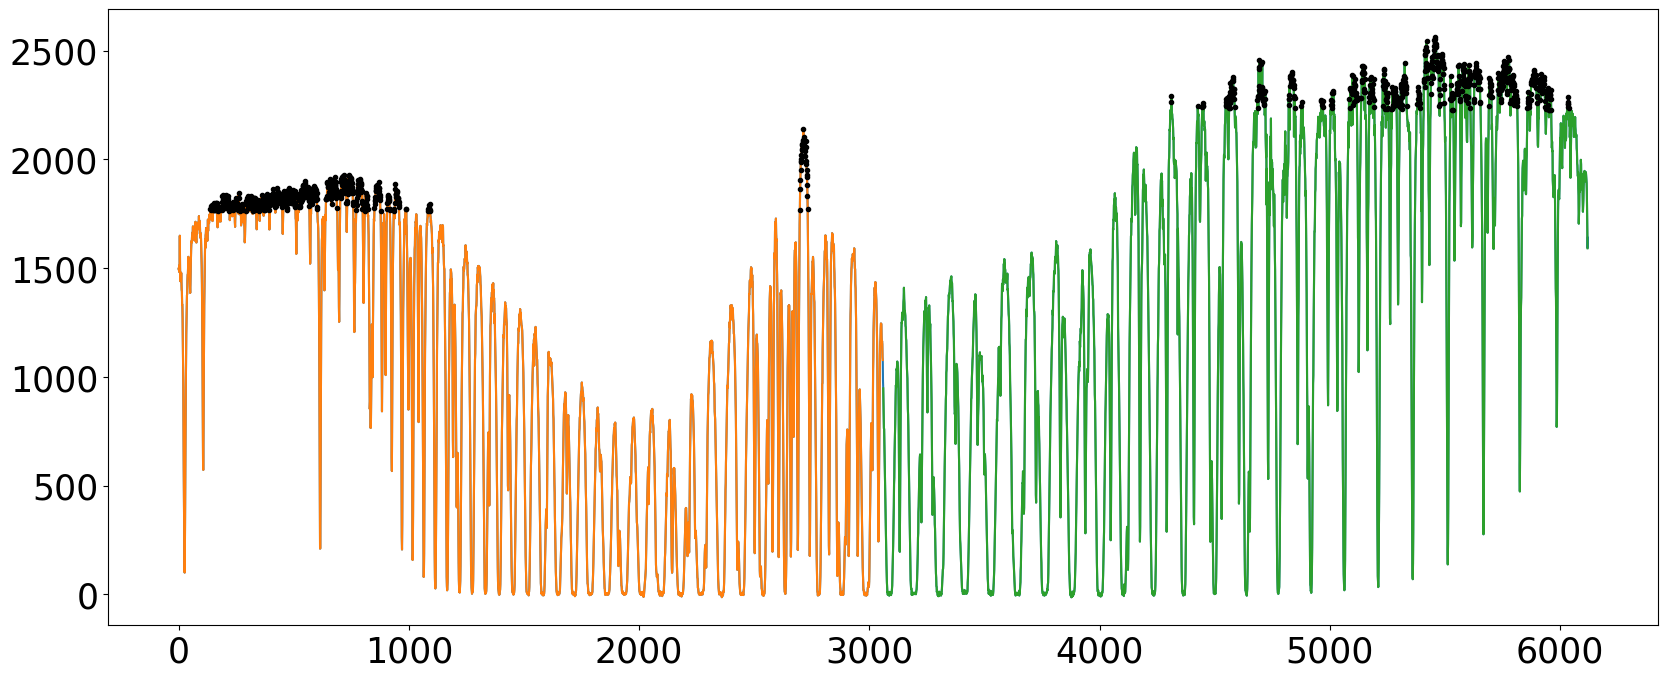

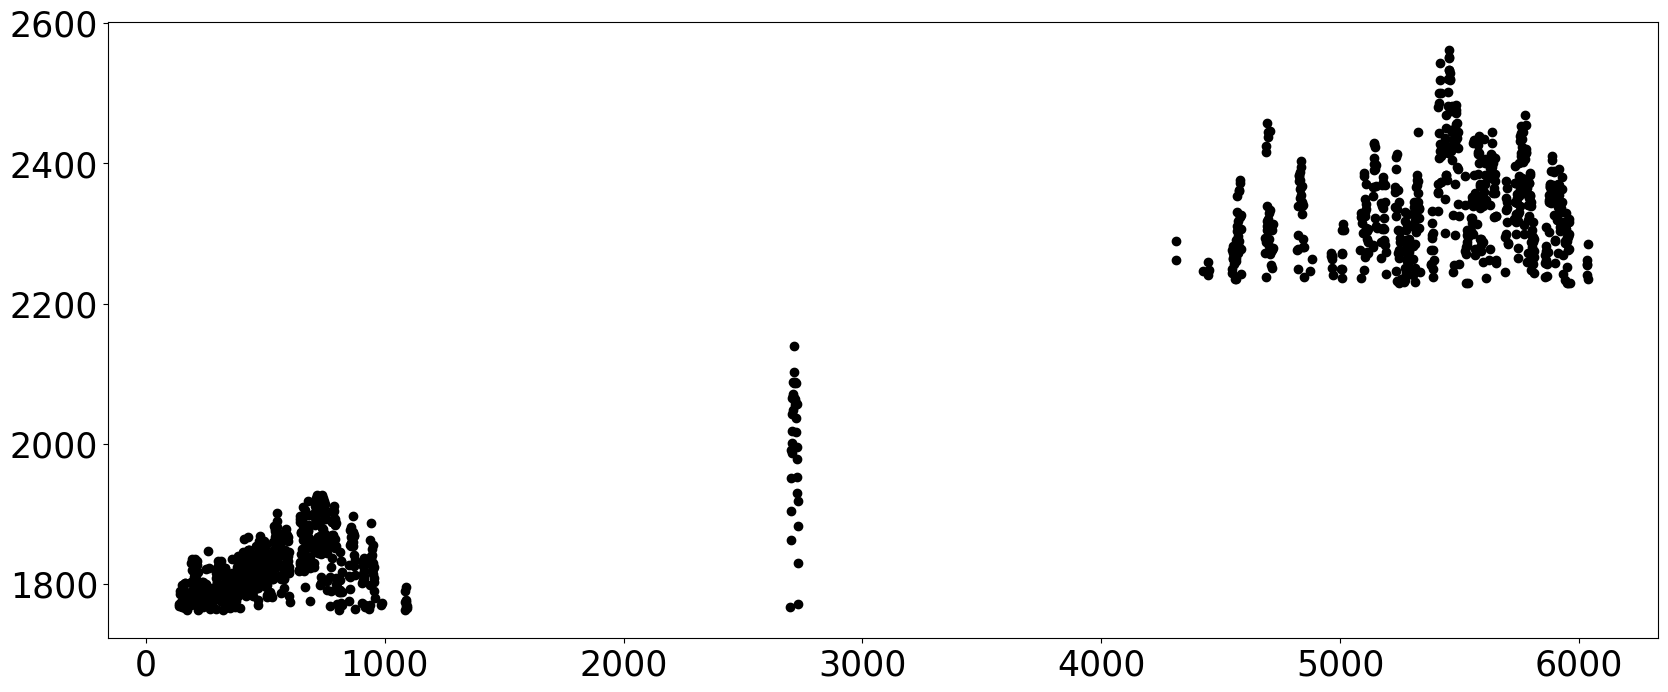

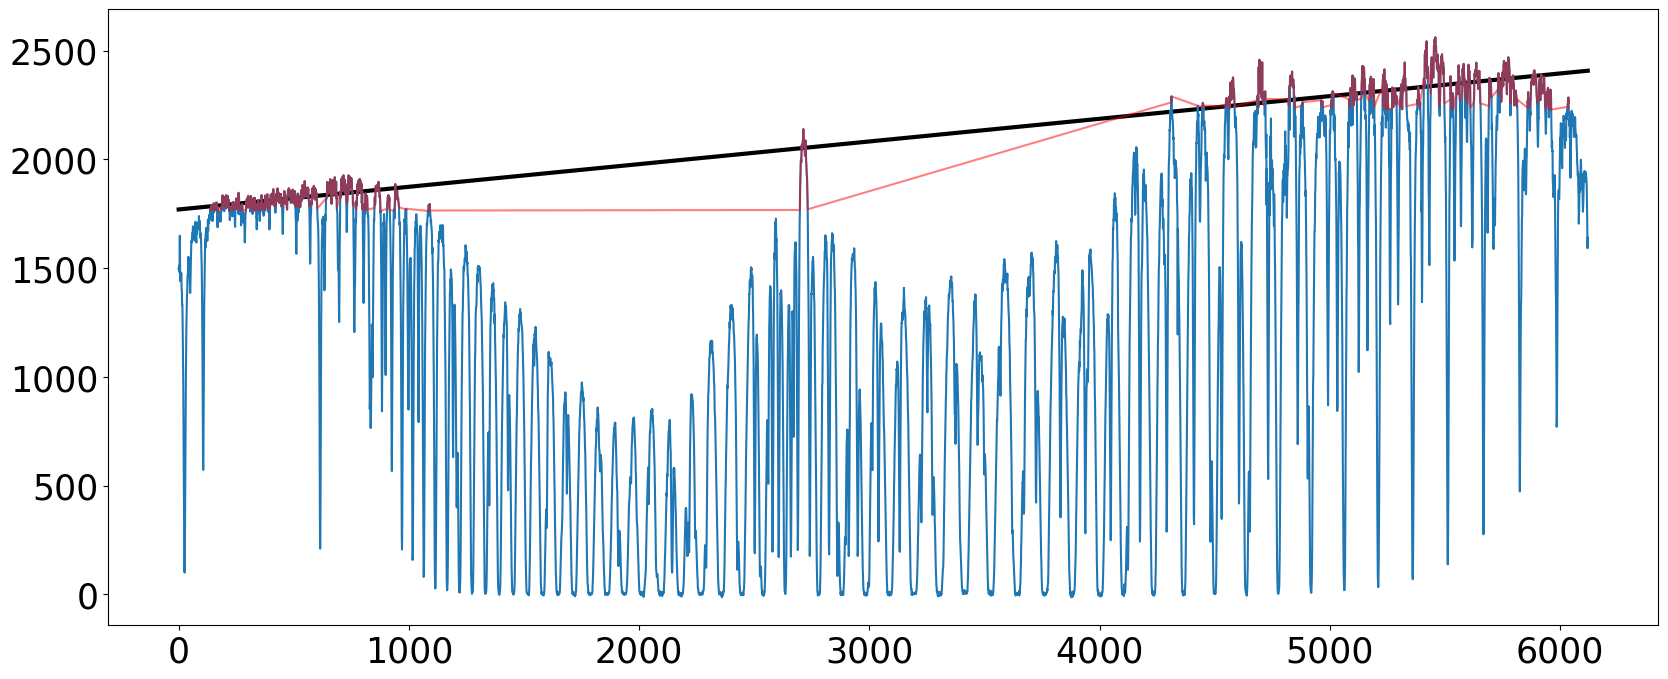

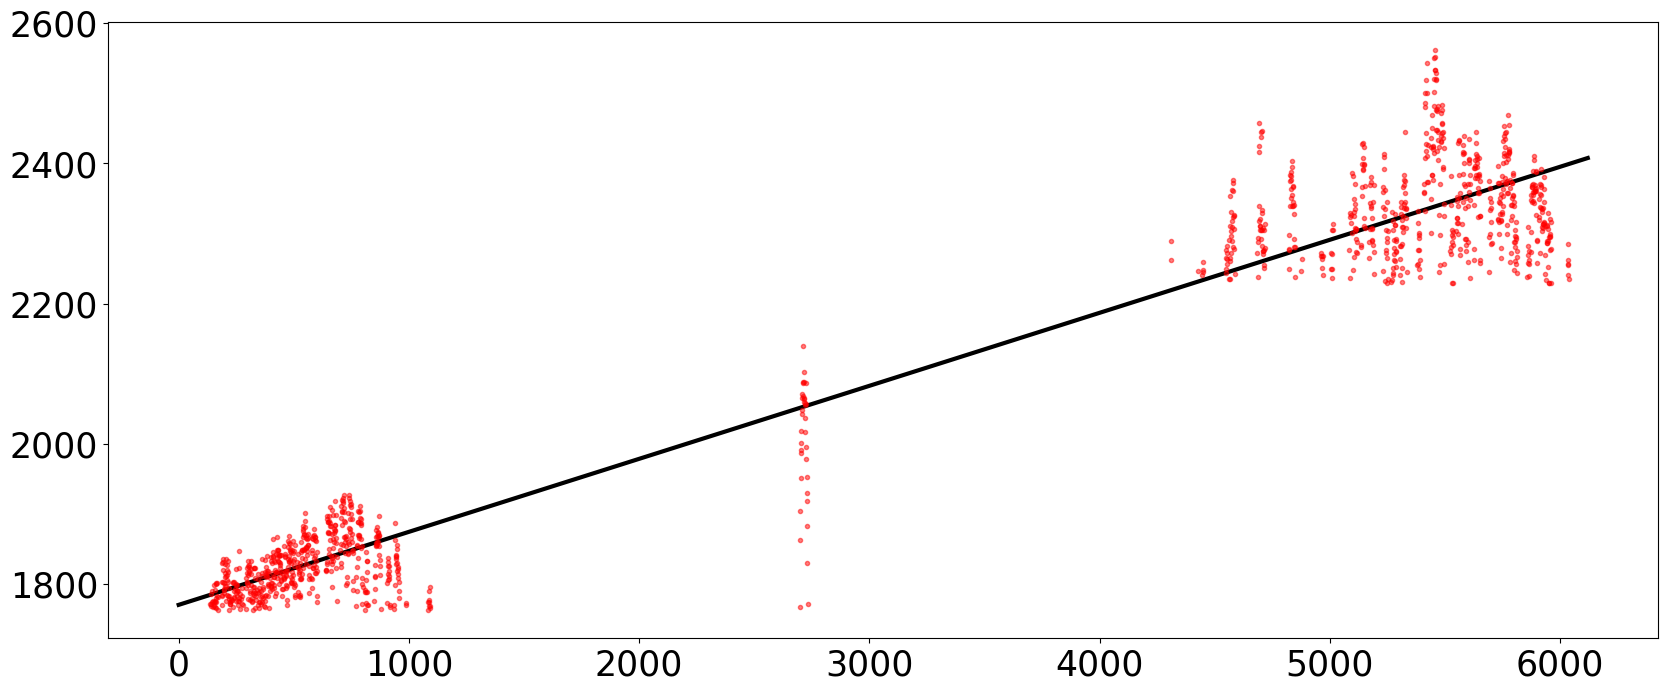

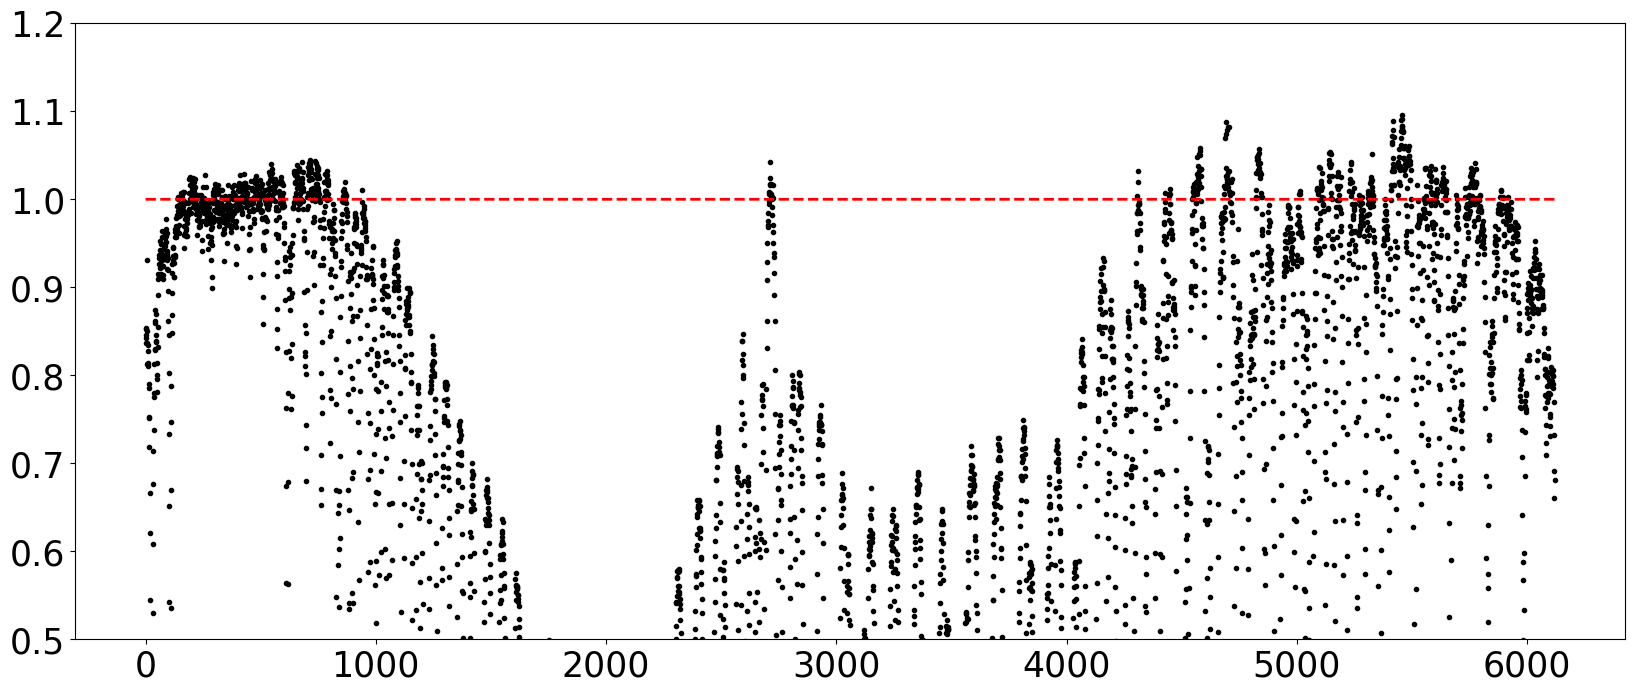

In [17]:
bins = 2
p_order = 2
fraction = 0.2
plot = True
wave_n, flux_n = Normalization(wave, flux, bins, p_order, fraction, plot, section=0)

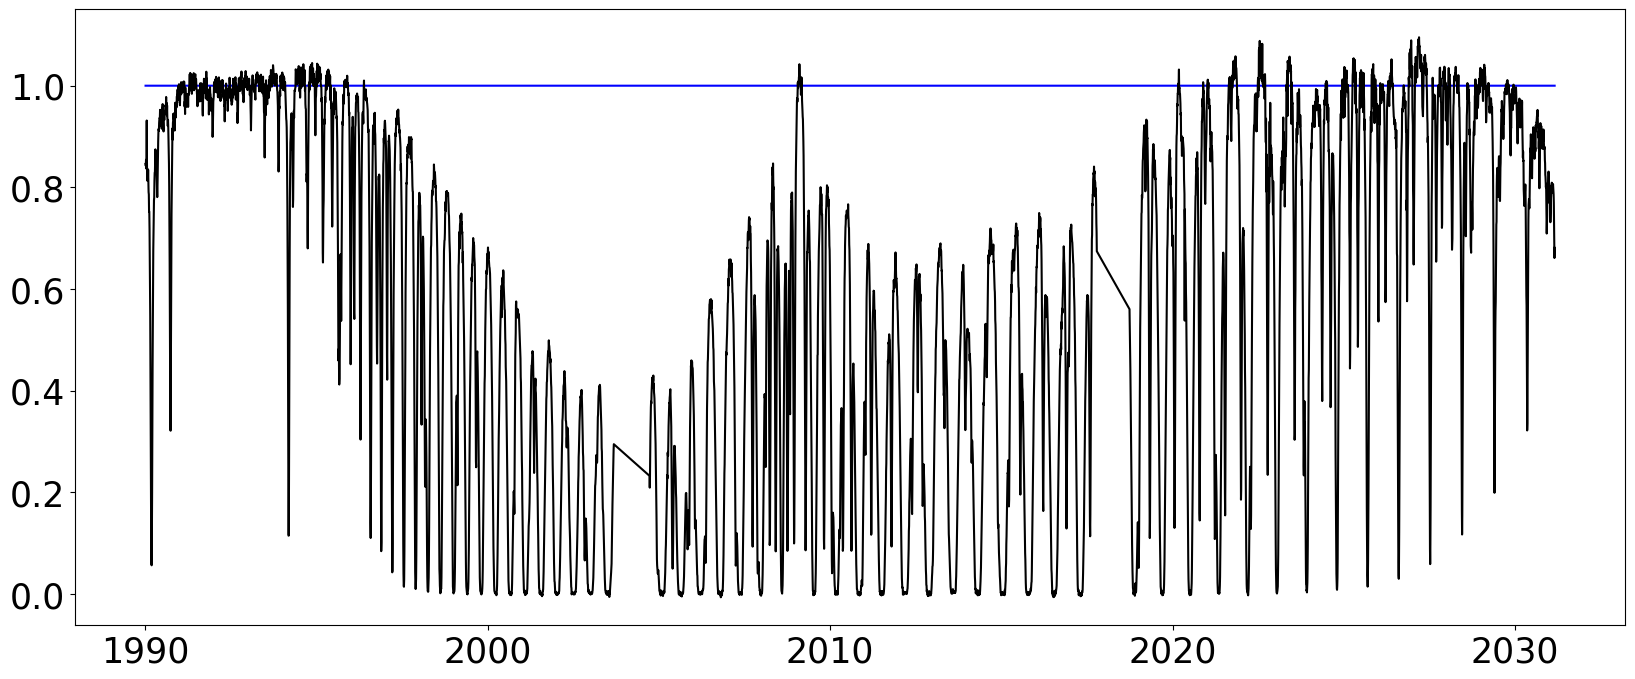

In [18]:
plt.plot(wave, np.ones_like(wave), 'b')
plt.plot(wave_n ,flux_n,'k')

full_wave_n.extend(wave_n)
full_flux_n.extend(flux_n)

# Testing Normalization part 2

6117


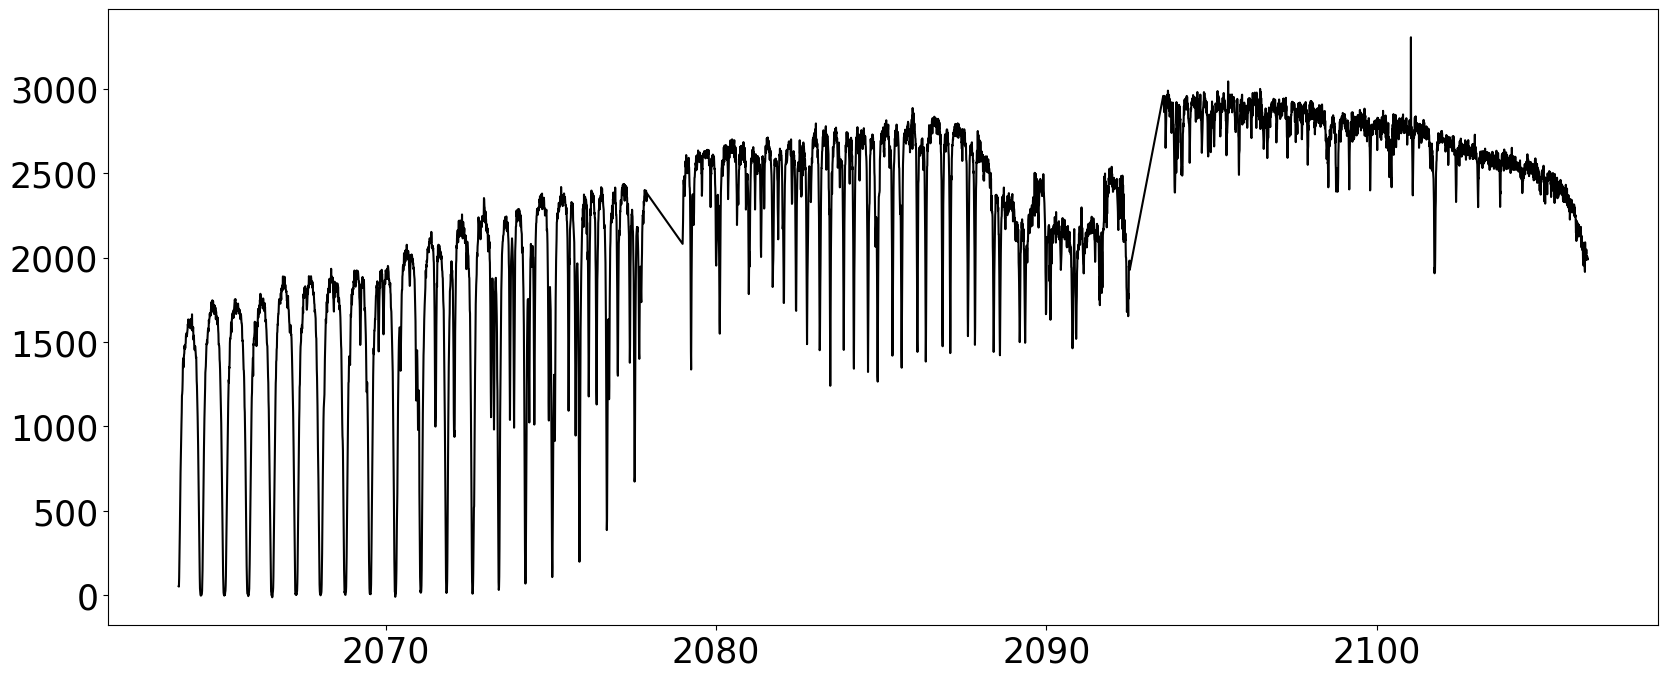

In [19]:
wave = []
flux = []

i = 4
wave.extend(frame_WL[frame][i][4:-4])
flux.extend(frame_spec[frame][i][4:-4])
i = 10
wave.extend(frame_WL[frame][i][4:-5])
flux.extend(frame_spec[frame][i][4:-5])
i = 16
wave.extend(frame_WL[frame][i][5:-5])
flux.extend(frame_spec[frame][i][5:-5])

print(len(wave))

wave = np.array(wave)
flux = np.array(flux)

plt.plot(wave,flux,'k')

[-9.79879087e-09 -8.80482689e-05  2.21352041e-01  2.79789332e+03]


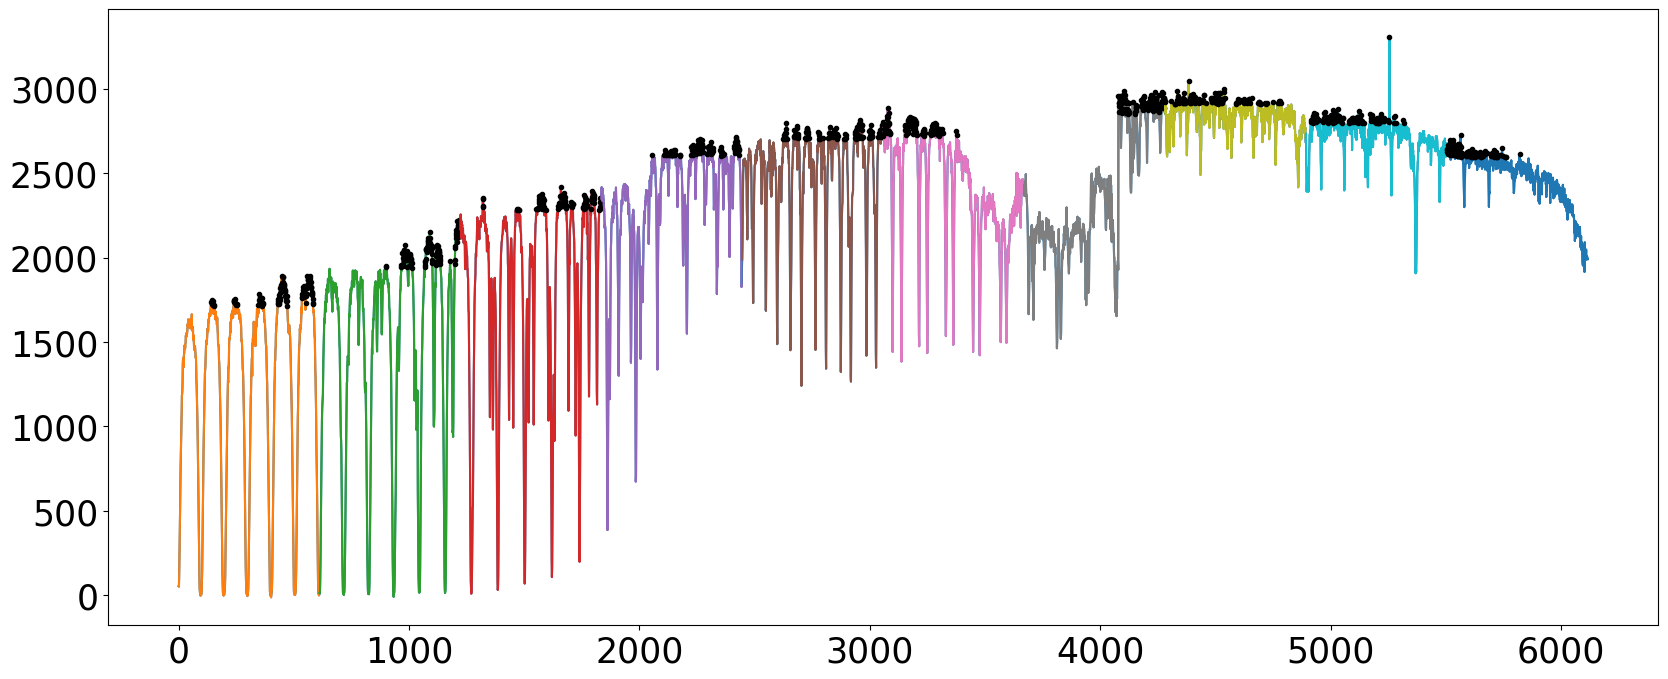

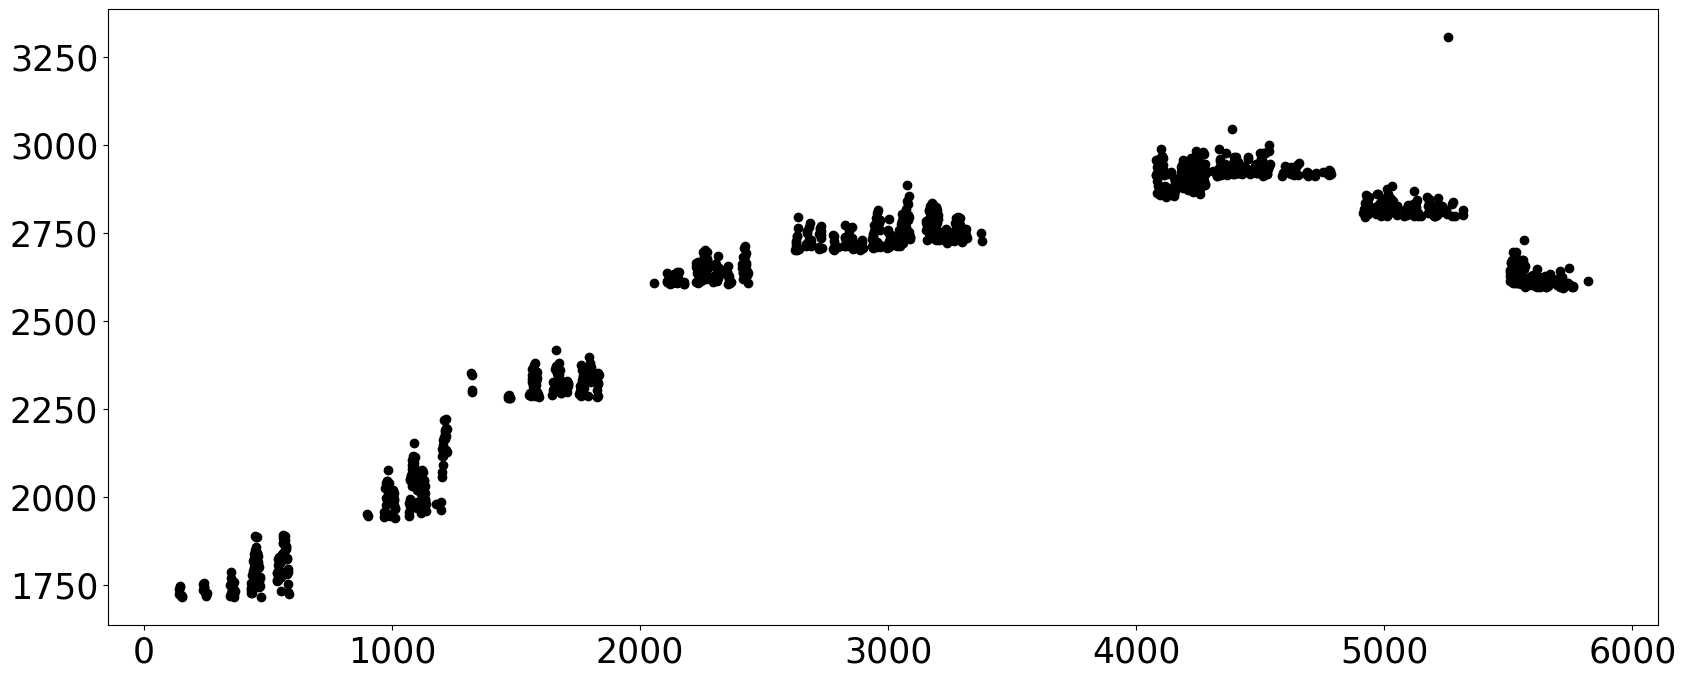

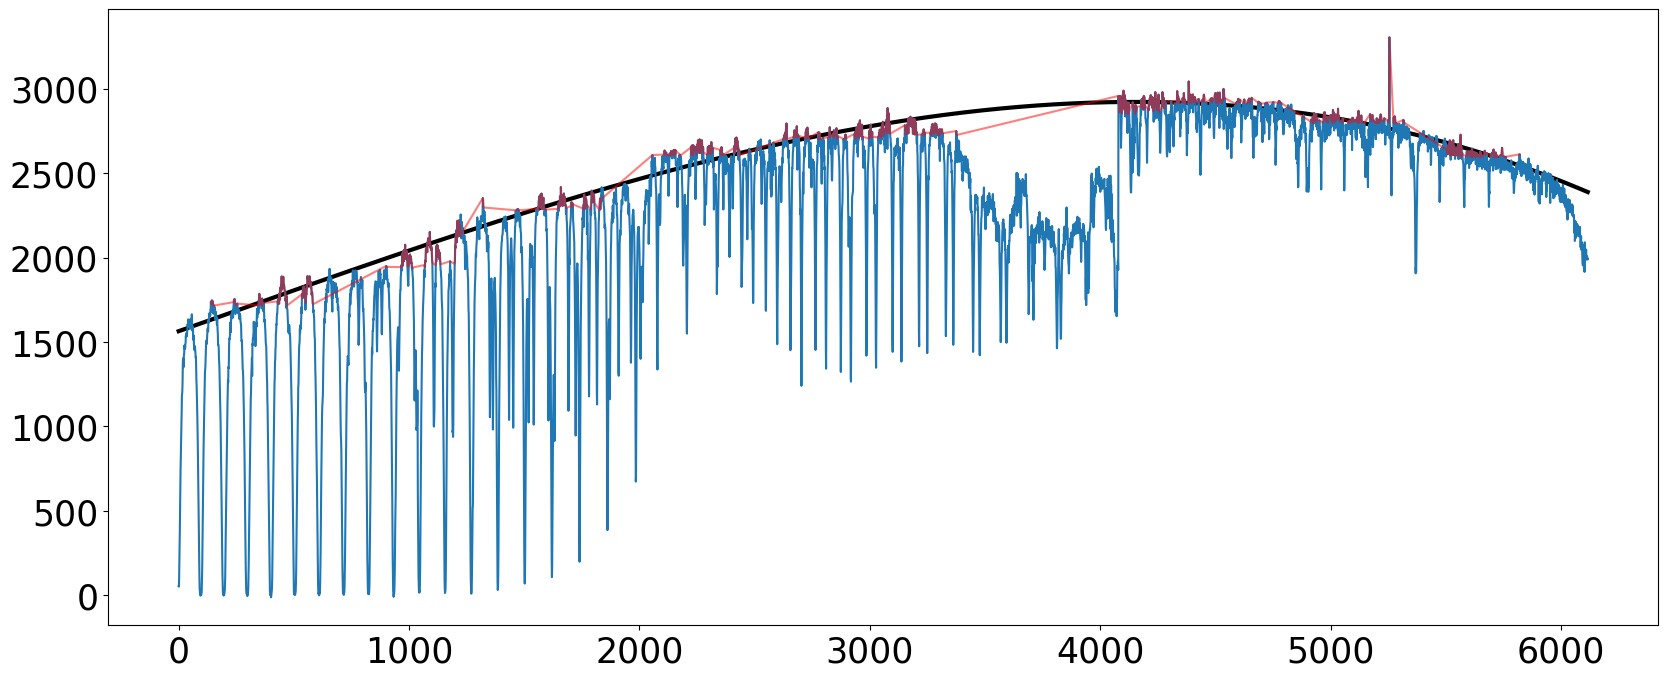

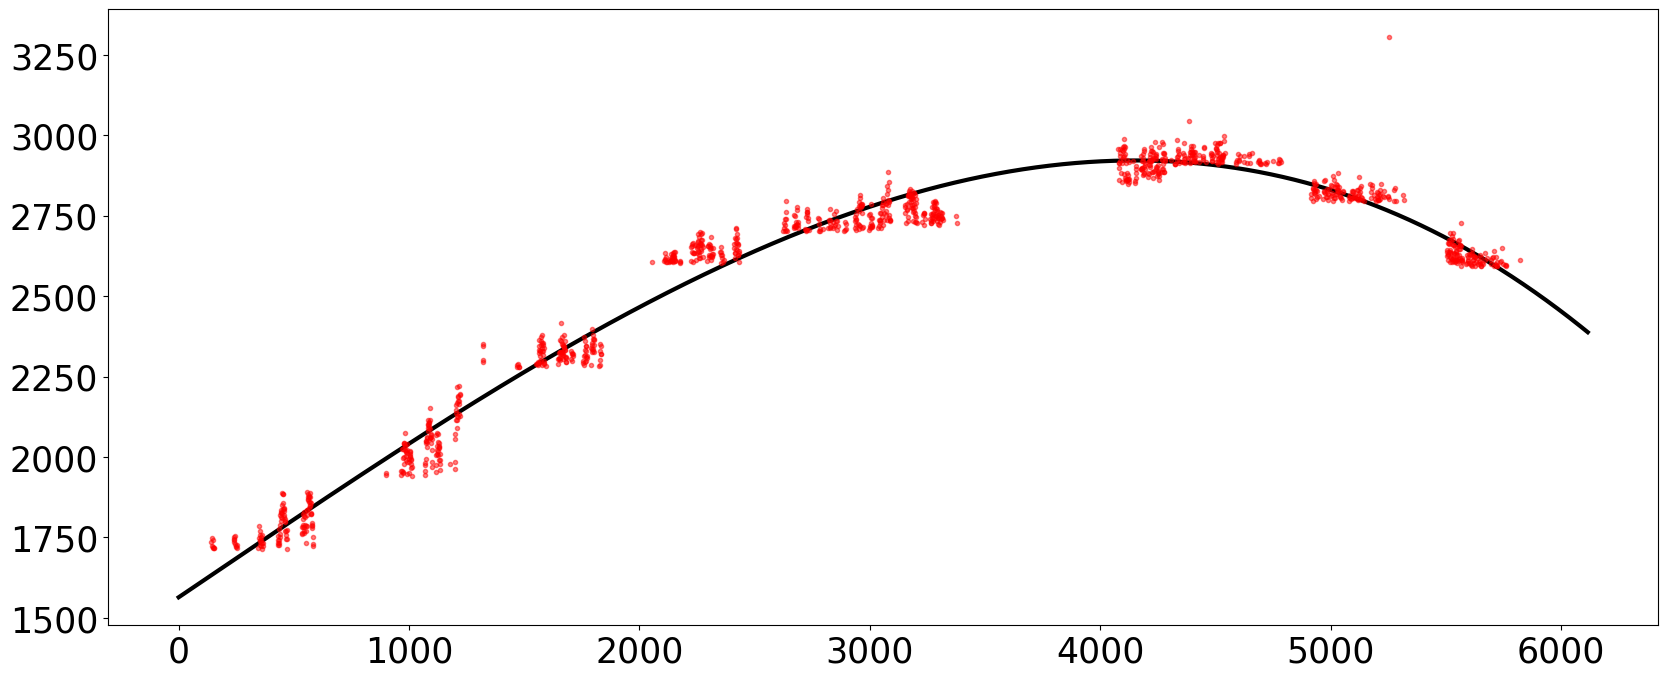

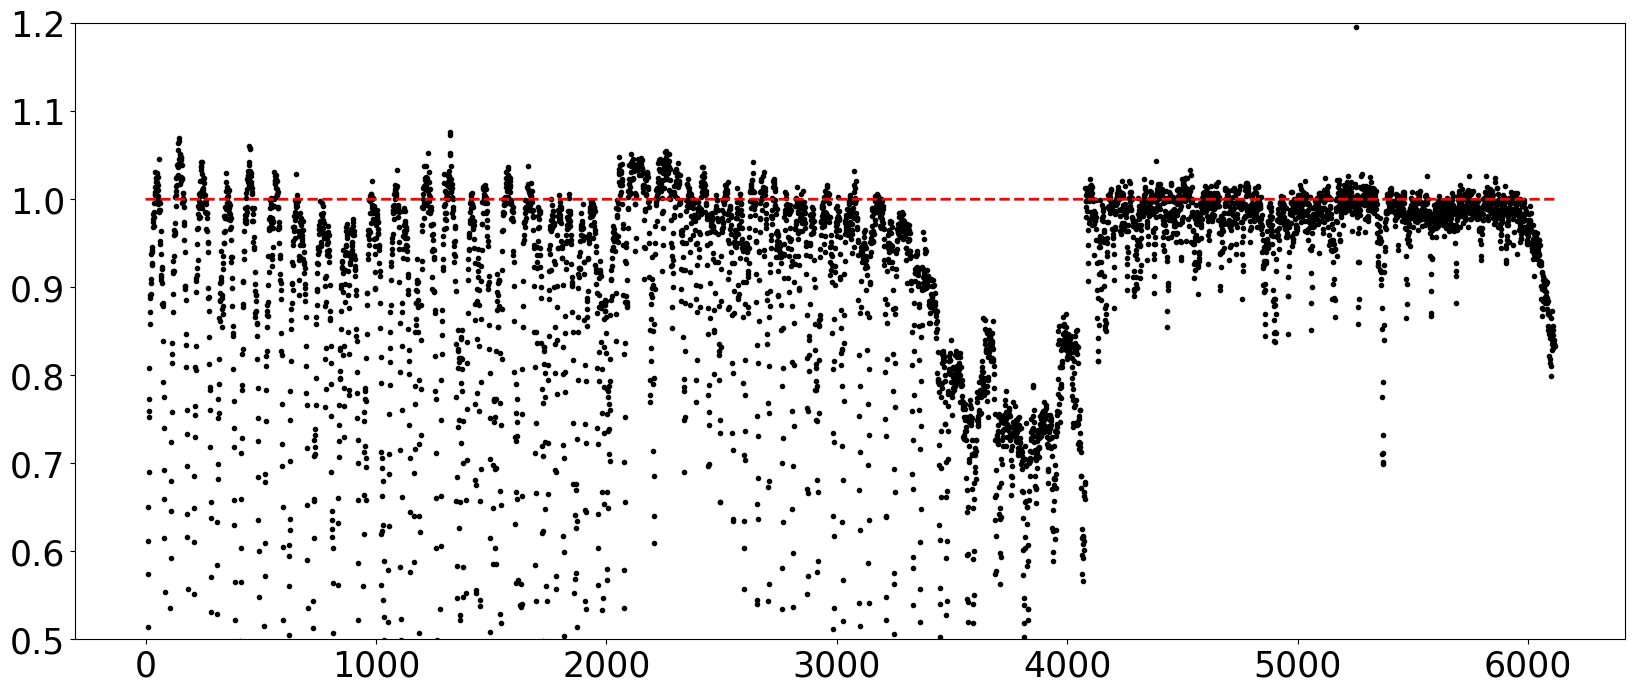

In [20]:
bins = 10
p_order = 3
fraction = 0.2
plot = True
wave_n, flux_n = Normalization(wave, flux, bins, p_order, fraction, plot, section=0)

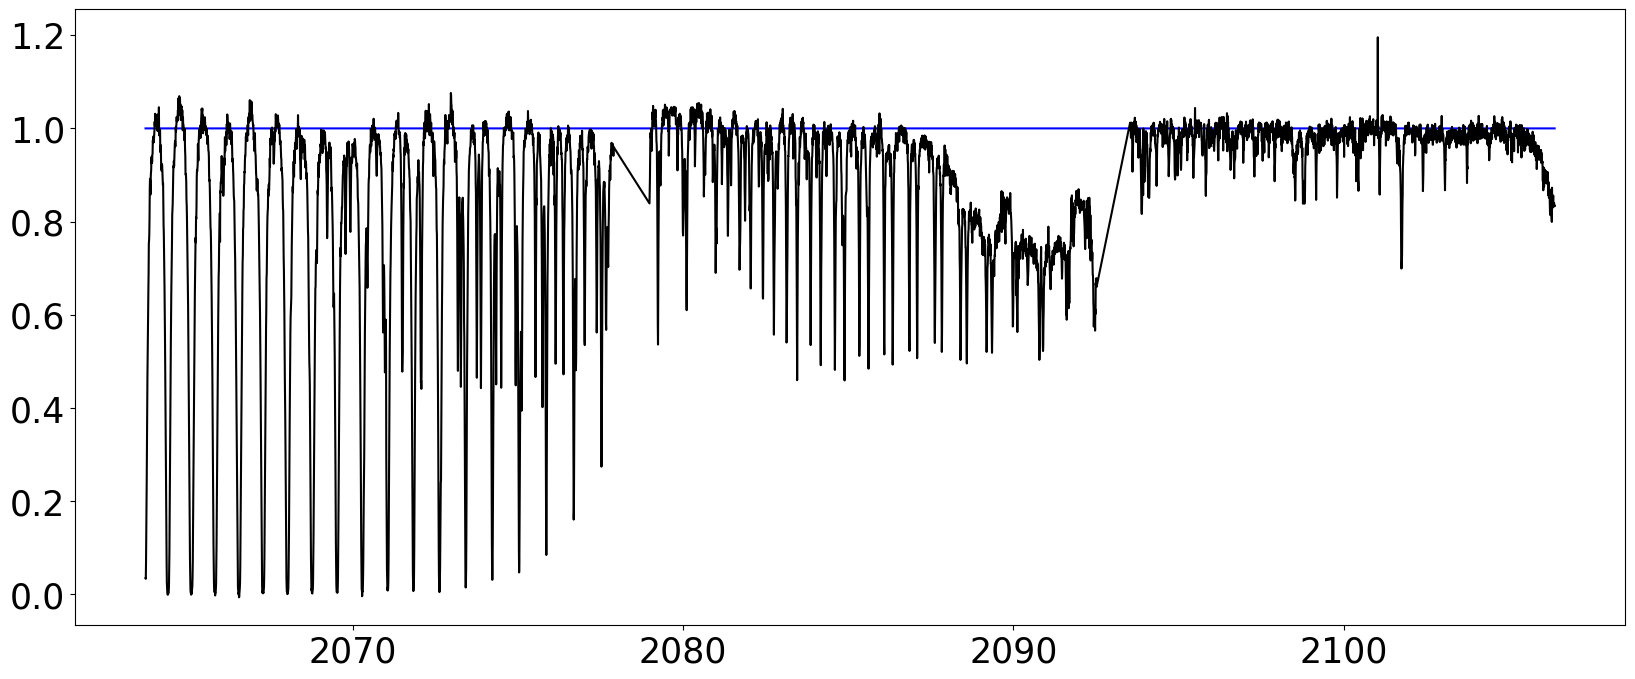

In [21]:
plt.plot(wave, np.ones_like(wave), 'b')
plt.plot(wave_n ,flux_n,'k')
full_wave_n.extend(wave_n)
full_flux_n.extend(flux_n)

# Testing Normalization part 3

6110


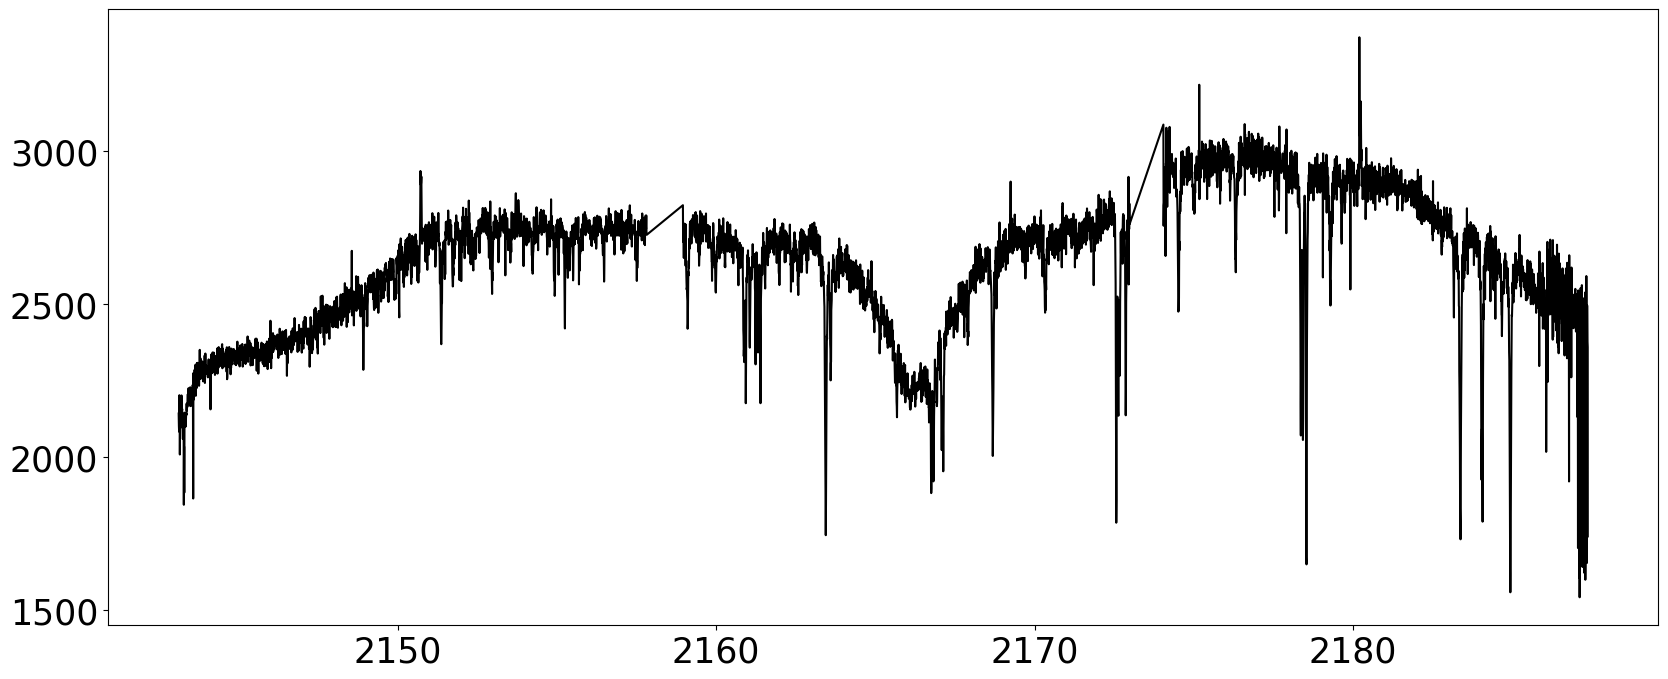

In [22]:
wave = []
flux = []

i = 3
wave.extend(frame_WL[frame][i][5:-5])
flux.extend(np.array(frame_spec[frame][i][5:-5]) +190)
i = 9
wave.extend(frame_WL[frame][i][6:-6])
flux.extend(frame_spec[frame][i][6:-6])
i = 15
wave.extend(frame_WL[frame][i][6:-6])
flux.extend(frame_spec[frame][i][6:-6])

print(len(wave))

wave = np.array(wave)
flux = np.array(flux)

plt.plot(wave,flux,'k')

[ 4.91695263e-18 -4.82527003e-16 -7.66422771e-11  2.65679047e-09
  2.81282416e-04  5.97861344e-02  2.63642129e+03]


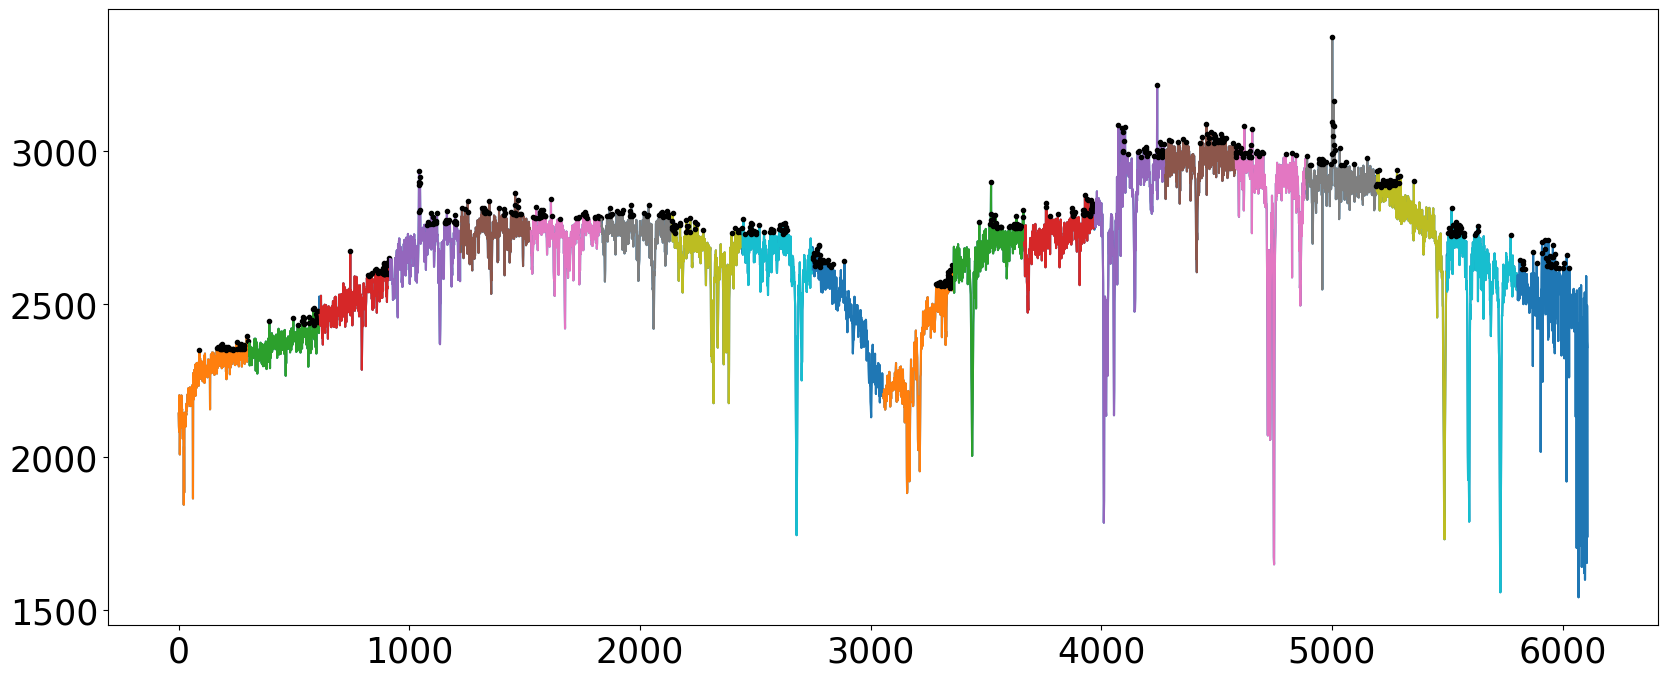

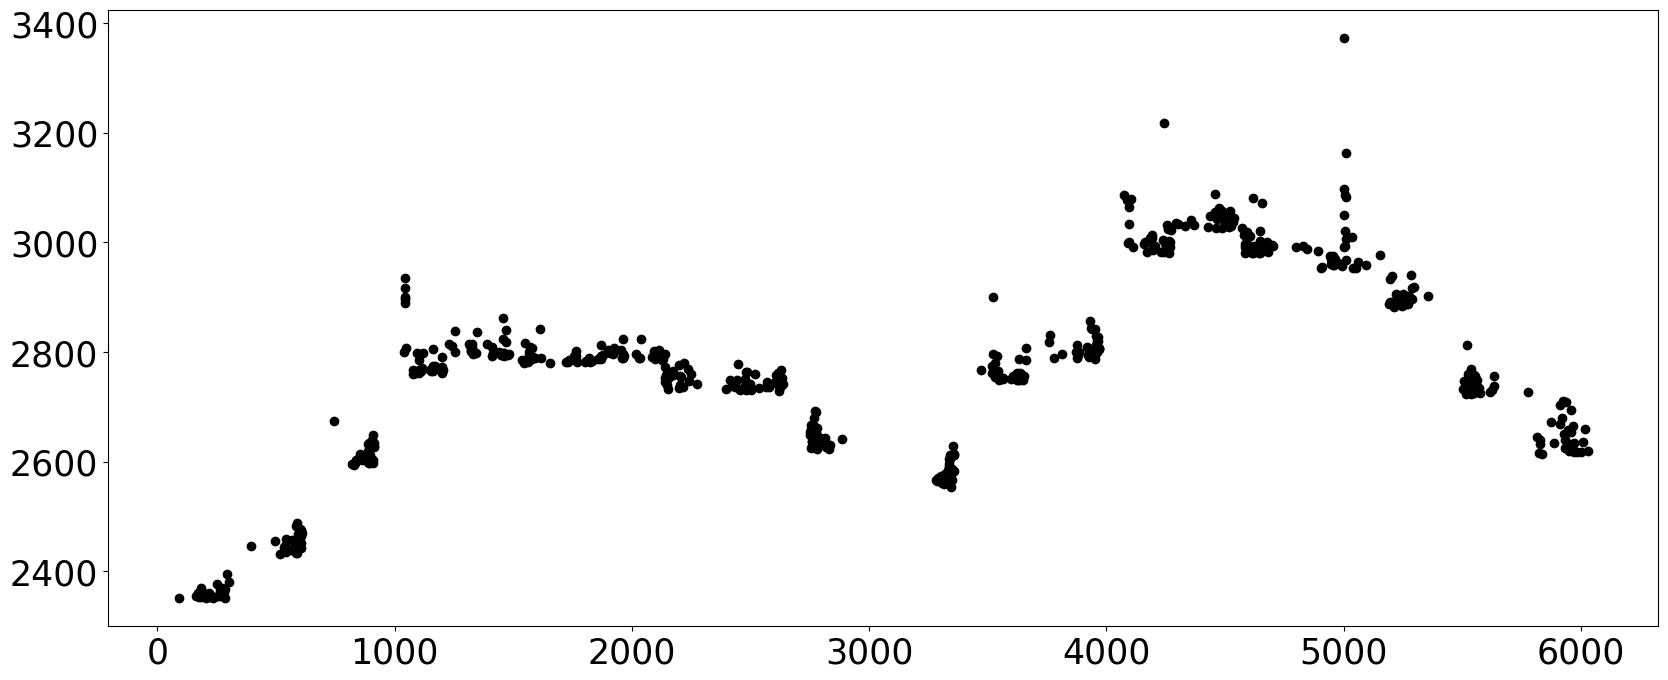

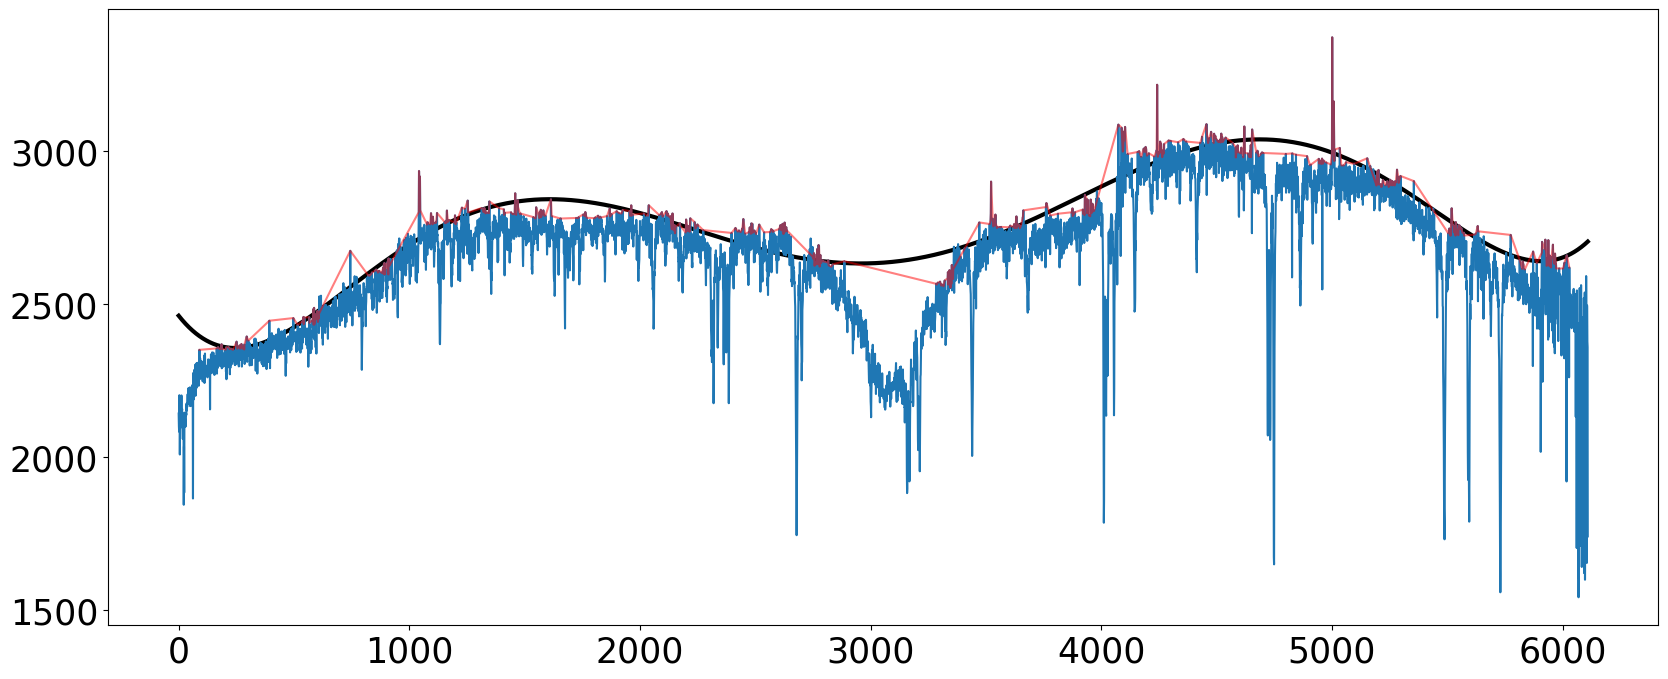

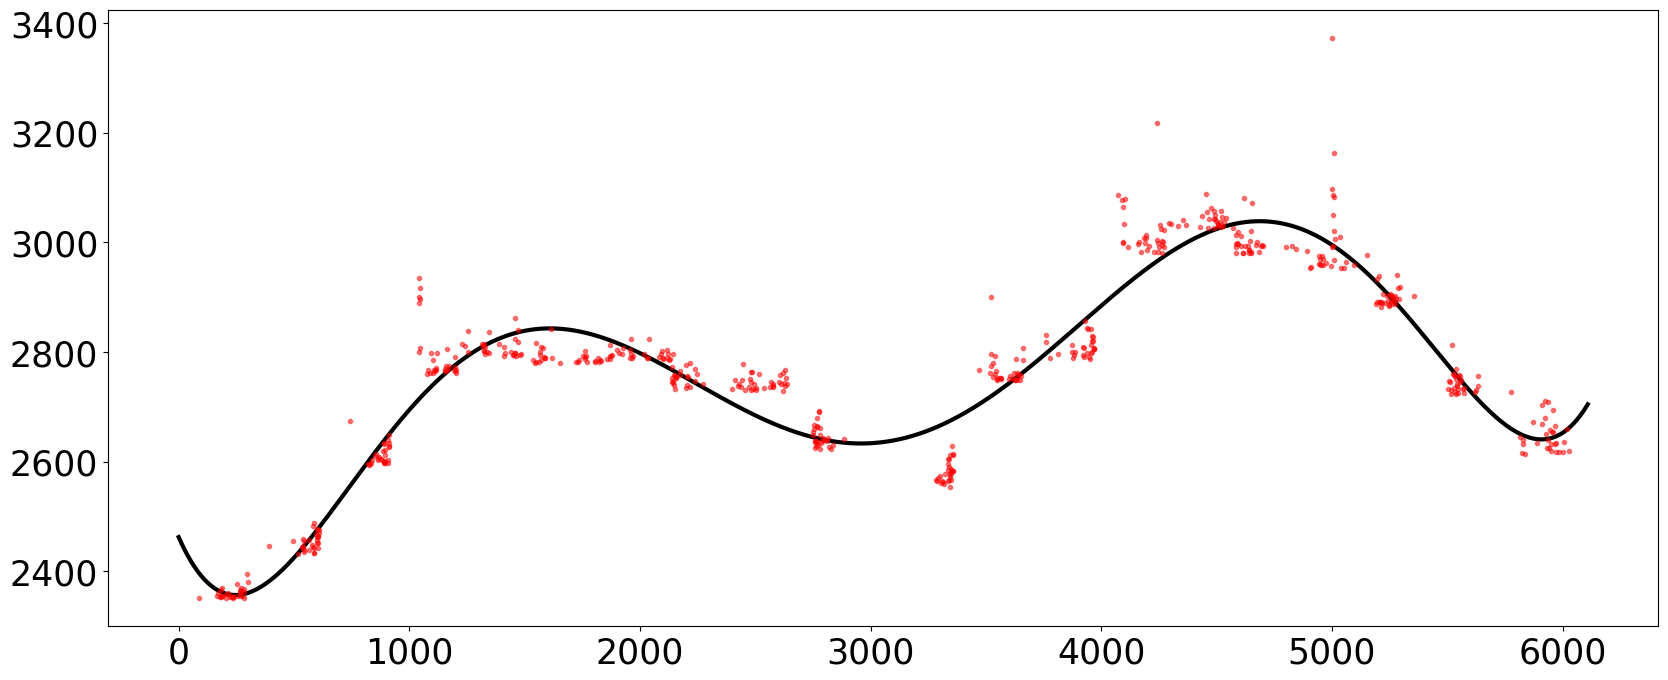

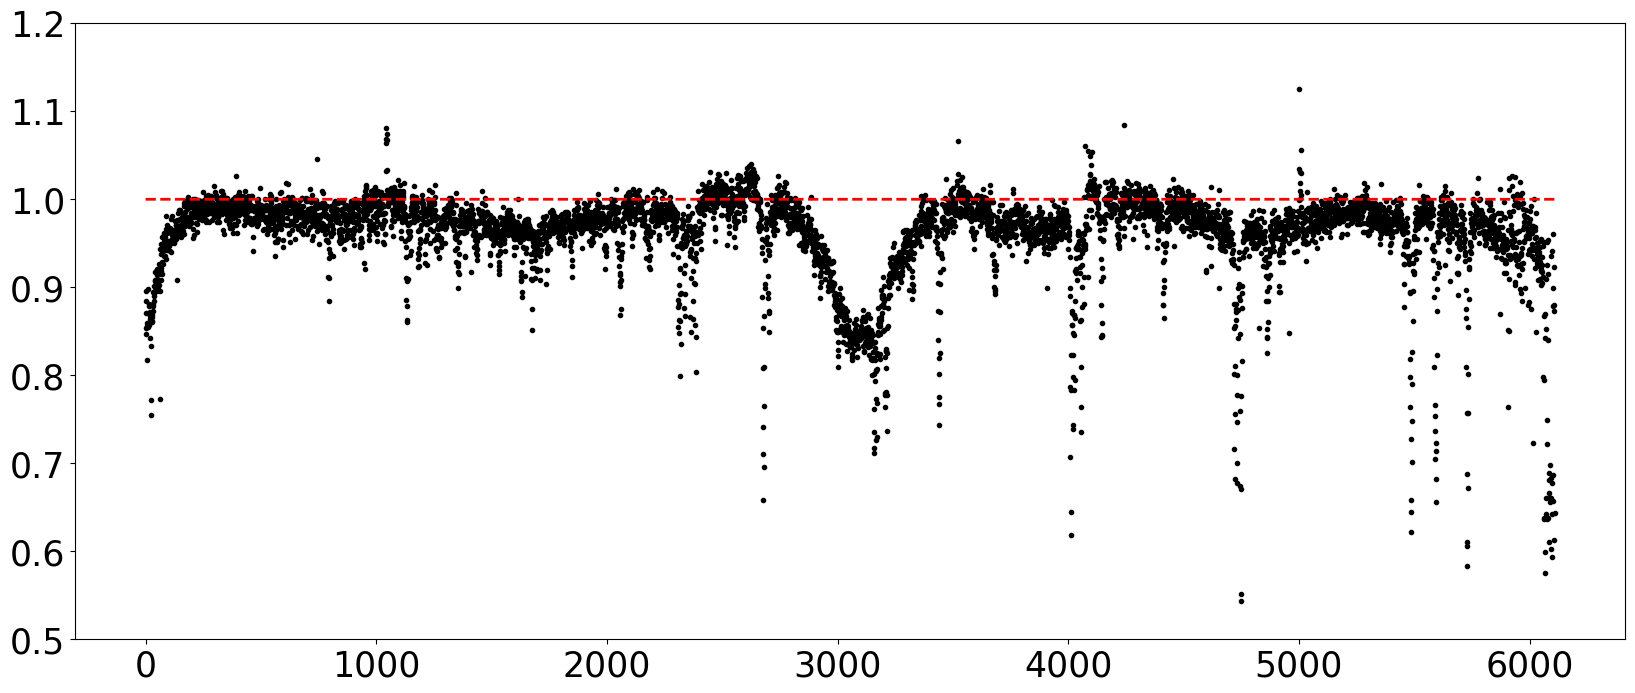

In [23]:
bins = 20
p_order = 6
fraction = 0.1
plot = True
wave_n, flux_n = Normalization(wave, flux, bins, p_order, fraction, plot, section=0)

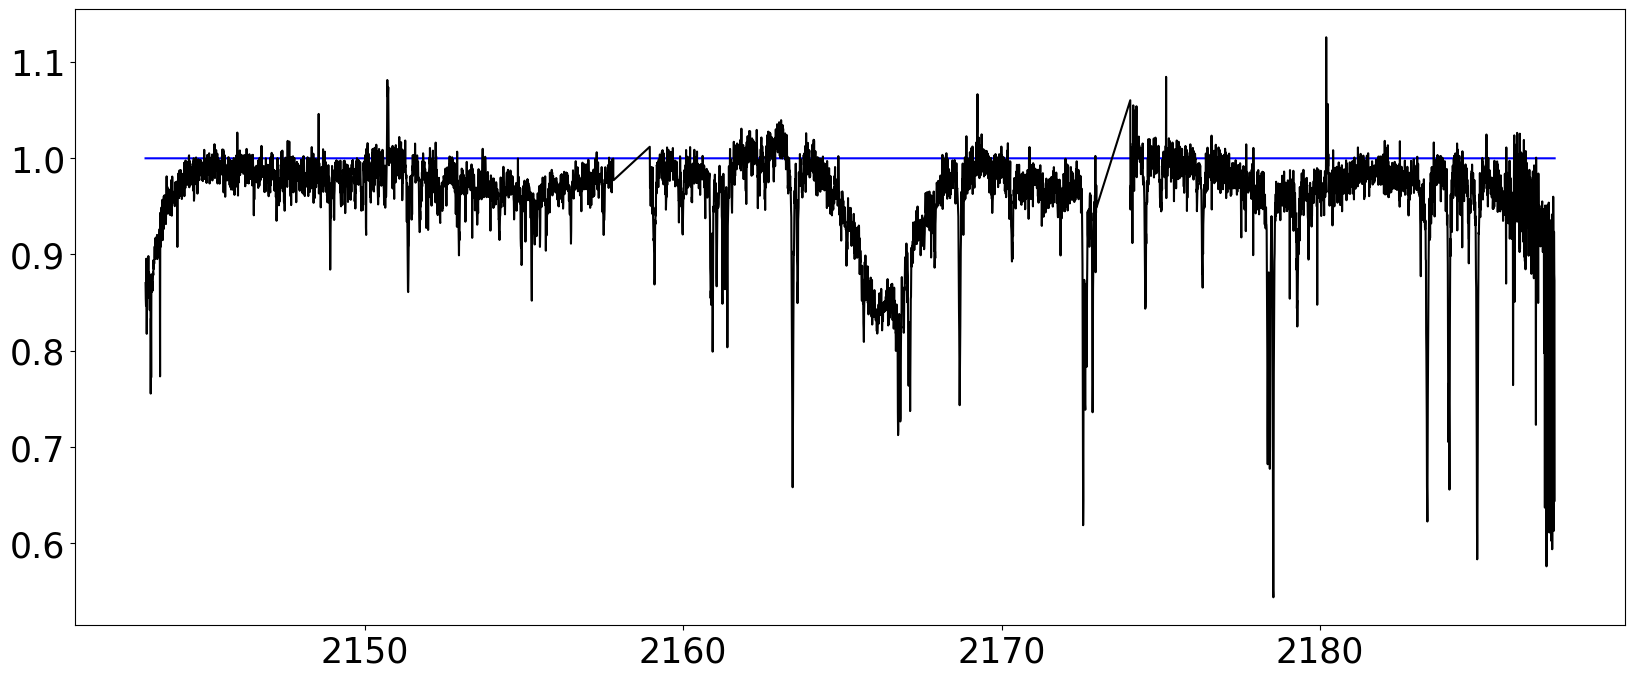

In [24]:
plt.plot(wave, np.ones_like(wave), 'b')
plt.plot(wave_n ,flux_n,'k')
full_wave_n.extend(wave_n)
full_flux_n.extend(flux_n)

# Testing Normalization part 4

6101


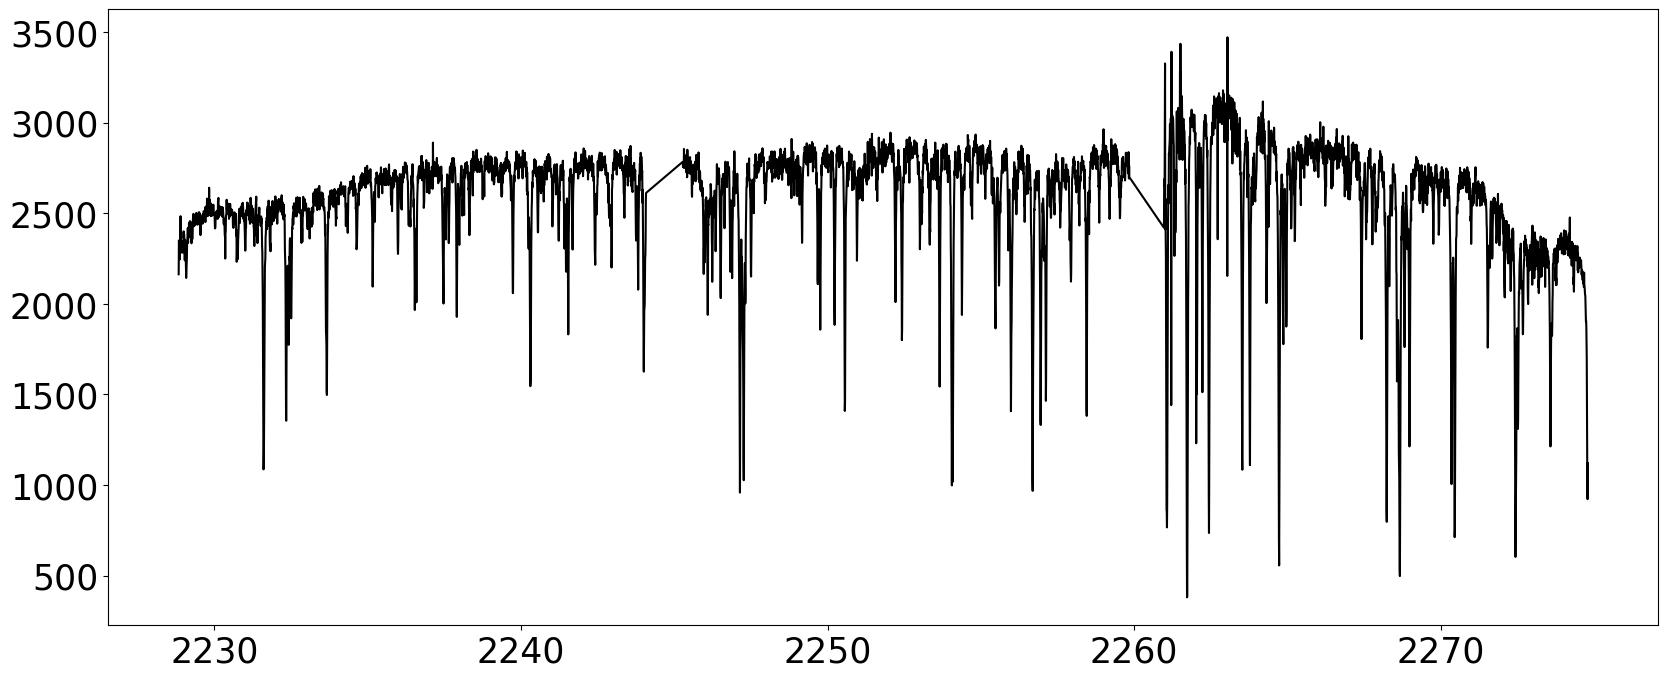

In [25]:
wave = []
flux = []

i = 2
wave.extend(frame_WL[frame][i][7:-7])
flux.extend(np.array(frame_spec[frame][i][7:-7])+190)
i = 8
wave.extend(frame_WL[frame][i][6:-7])
flux.extend(frame_spec[frame][i][6:-7])
i = 14
wave.extend(frame_WL[frame][i][8:-8])
flux.extend(frame_spec[frame][i][8:-8])

print(len(wave))

wave = np.array(wave)
flux = np.array(flux)

plt.plot(wave,flux,'k')

[ 1.80754677e-18  4.86220572e-16 -3.09066563e-11 -1.93216966e-08
  8.54957167e-05  1.00506072e-01  2.85922149e+03]


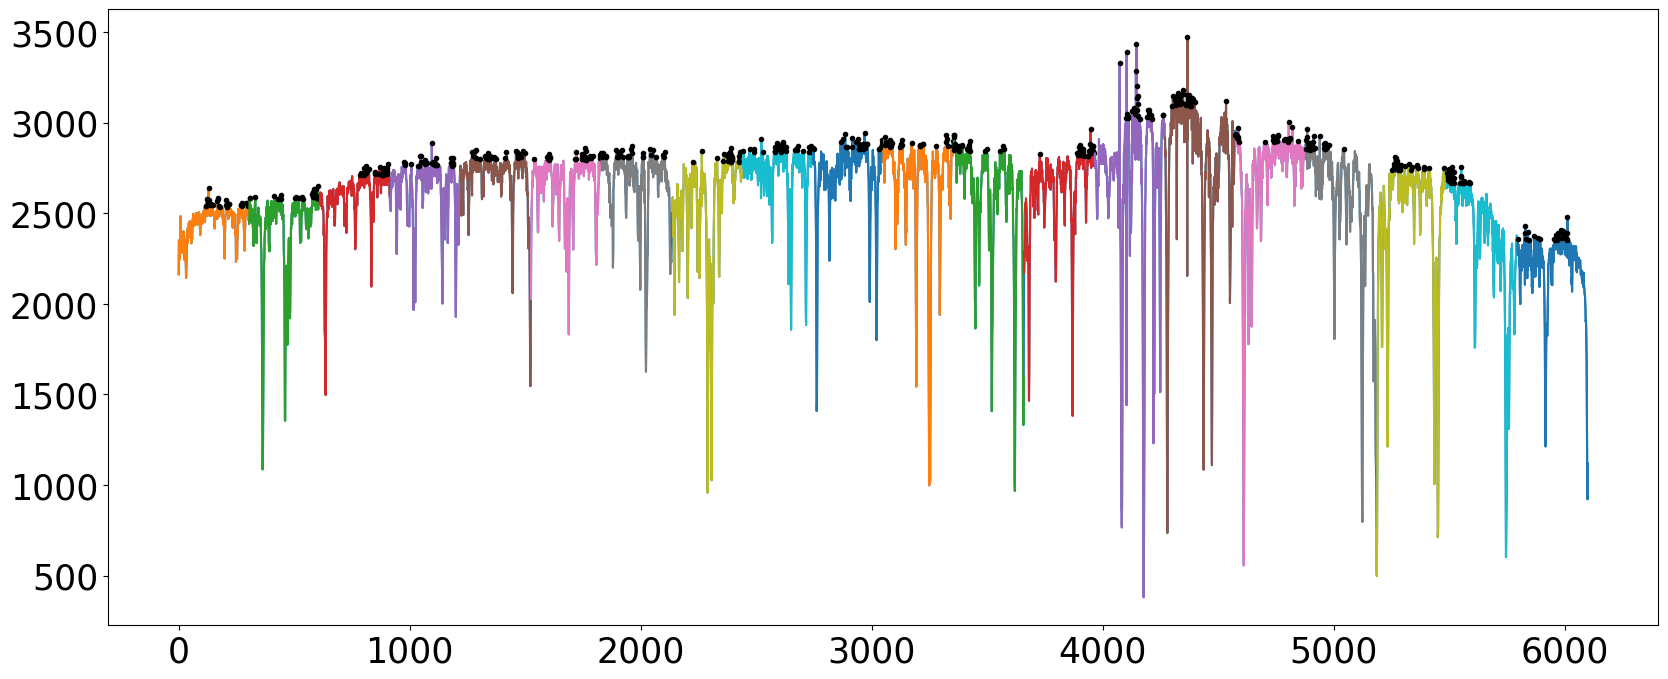

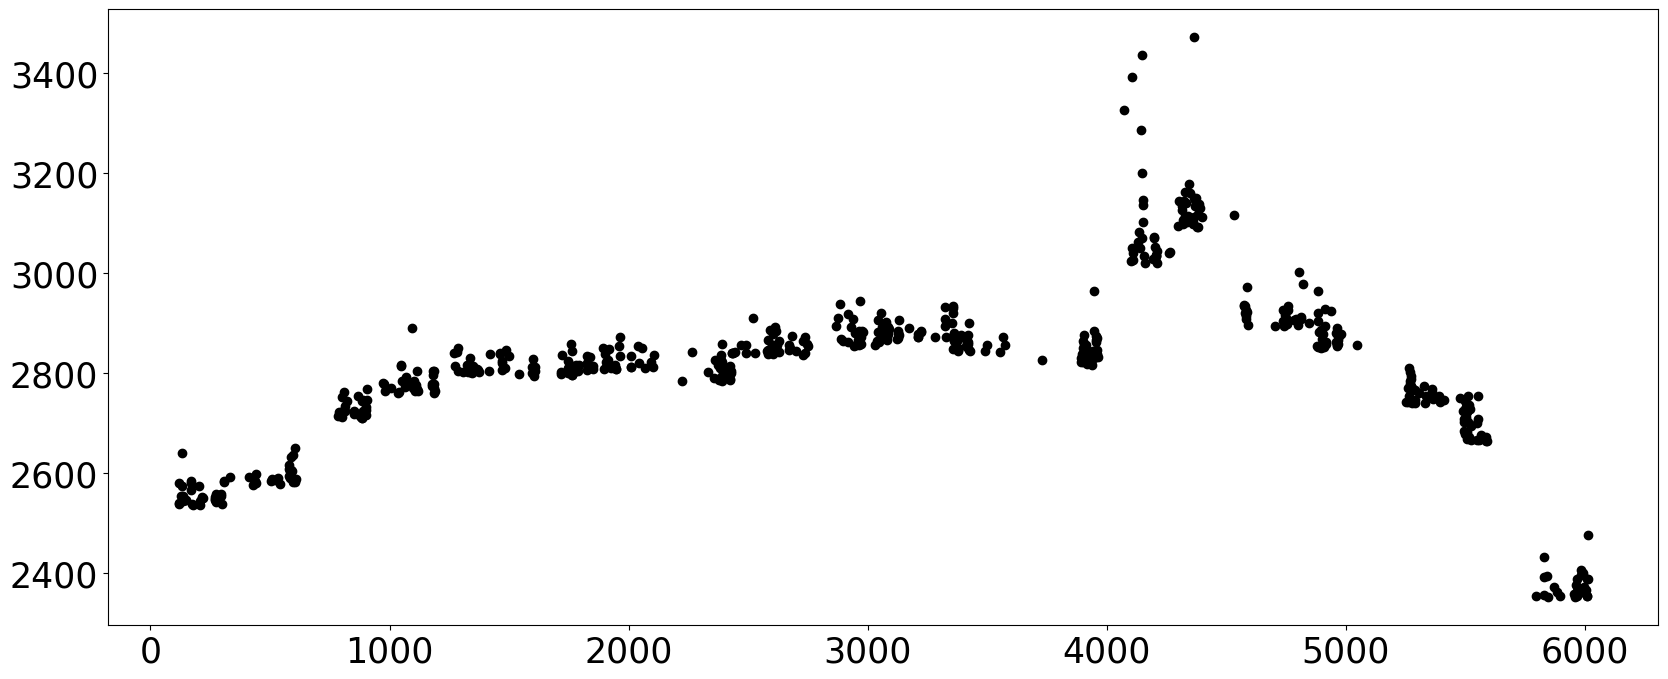

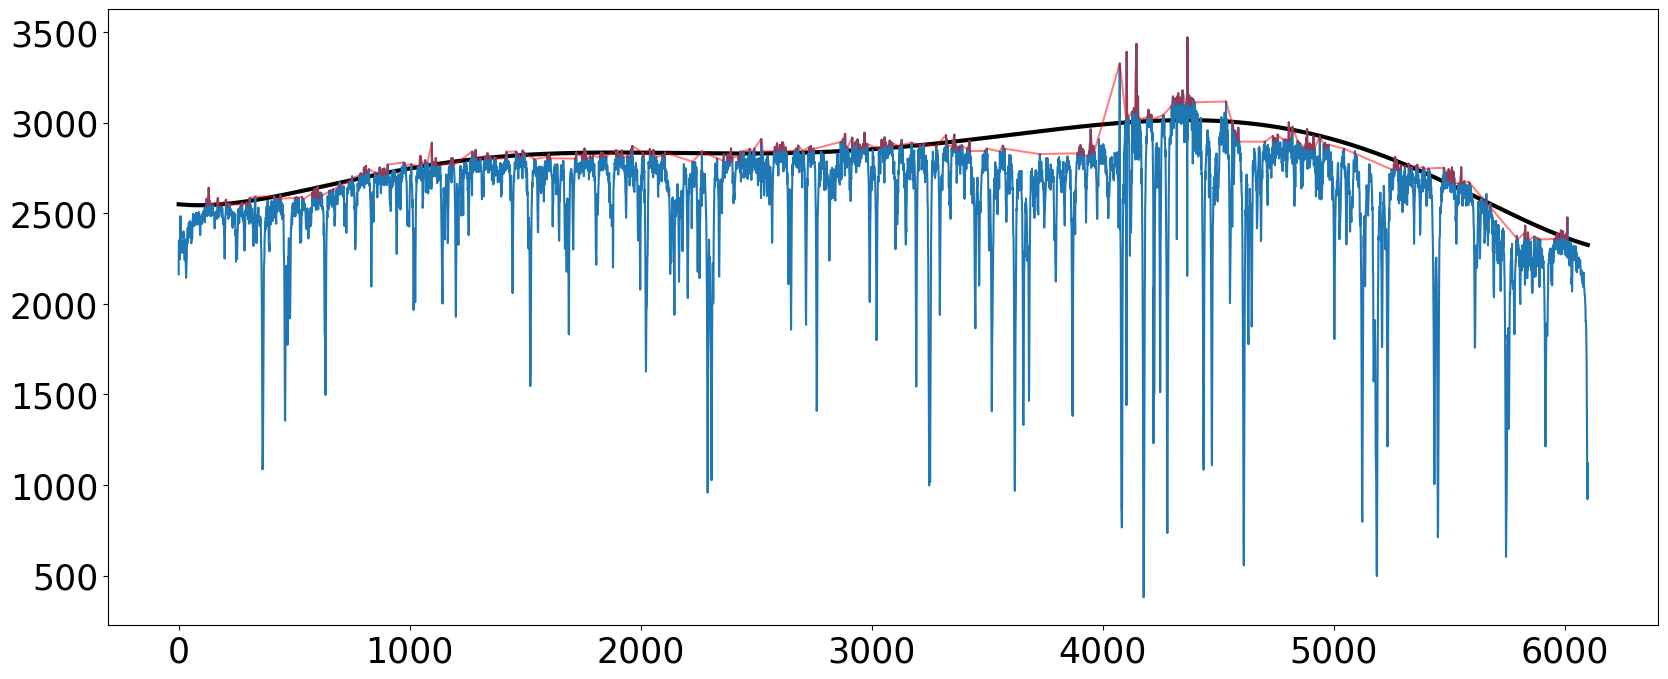

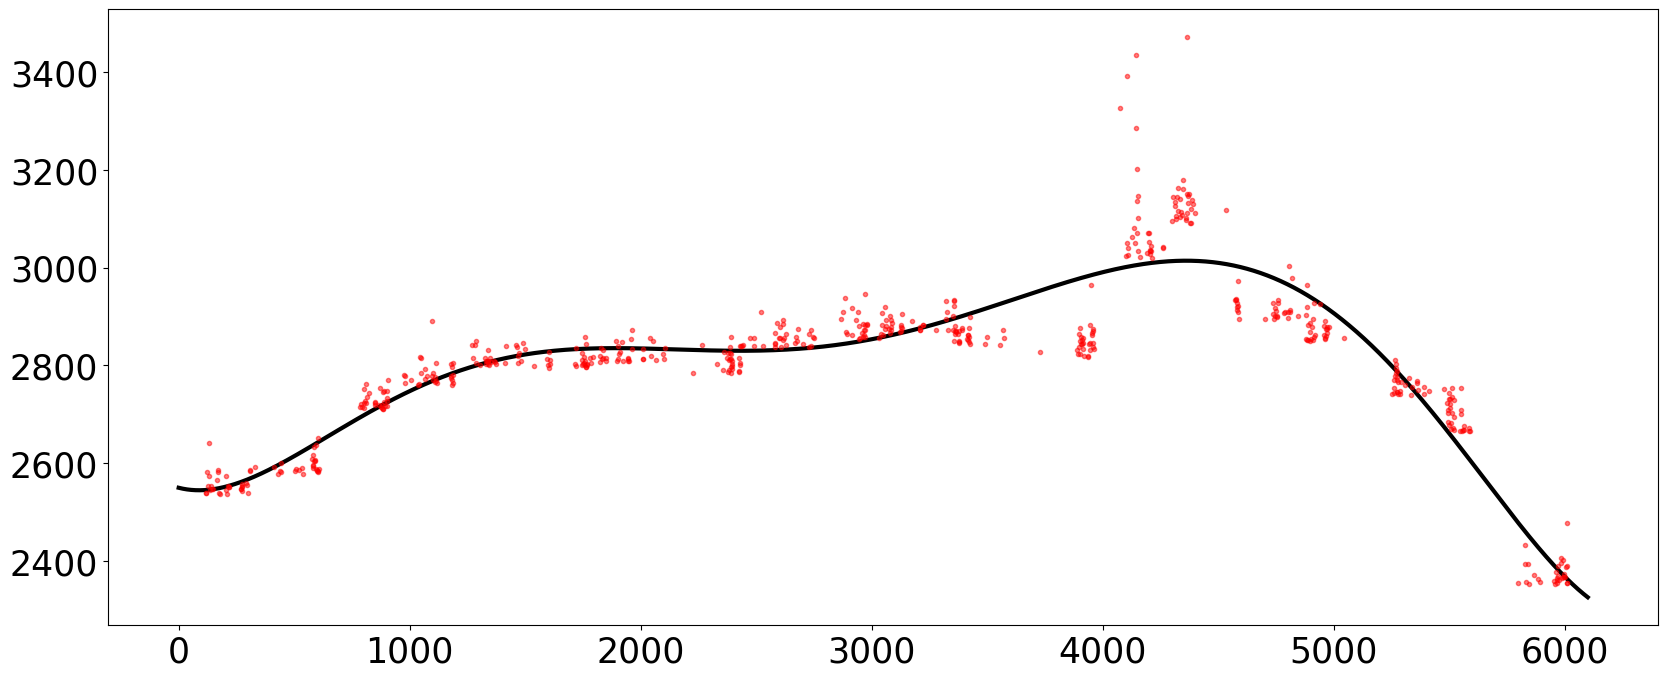

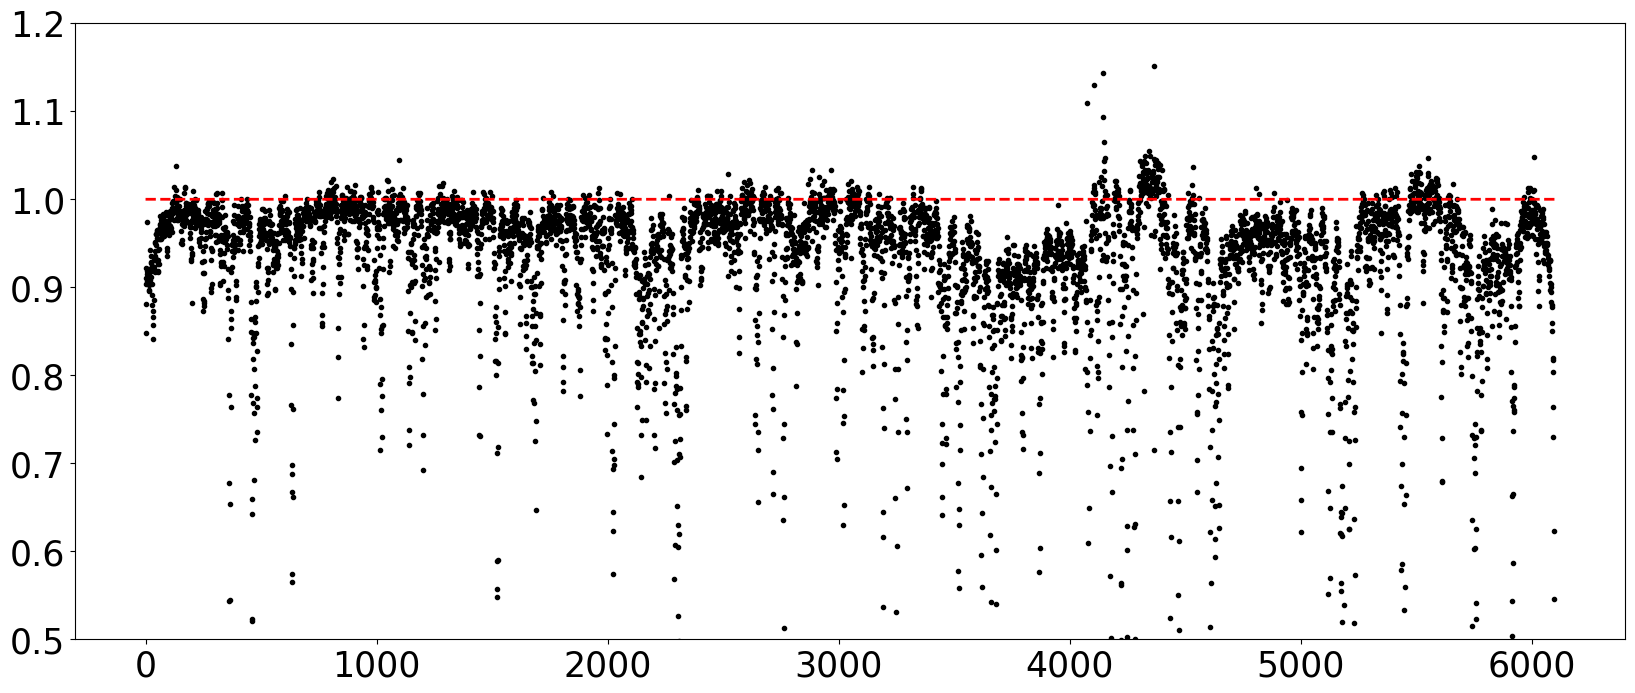

In [26]:
bins = 20
p_order = 6
fraction = 0.1
plot = True
wave_n, flux_n = Normalization(wave, flux, bins, p_order, fraction, plot, section=0)

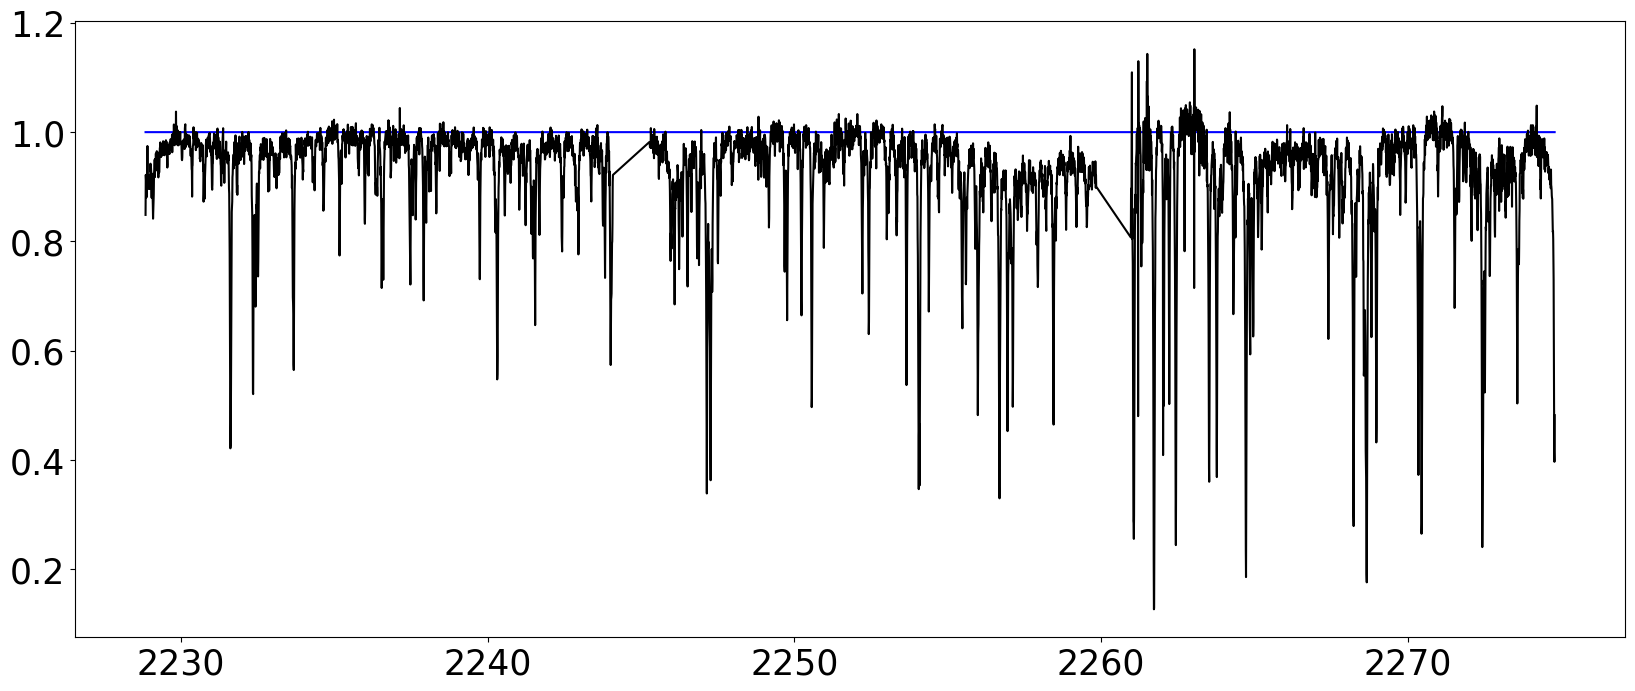

In [27]:
plt.plot(wave, np.ones_like(wave), 'b')
plt.plot(wave_n ,flux_n,'k')
full_wave_n.extend(wave_n)
full_flux_n.extend(flux_n)

# Testing Normalization part 6

6093


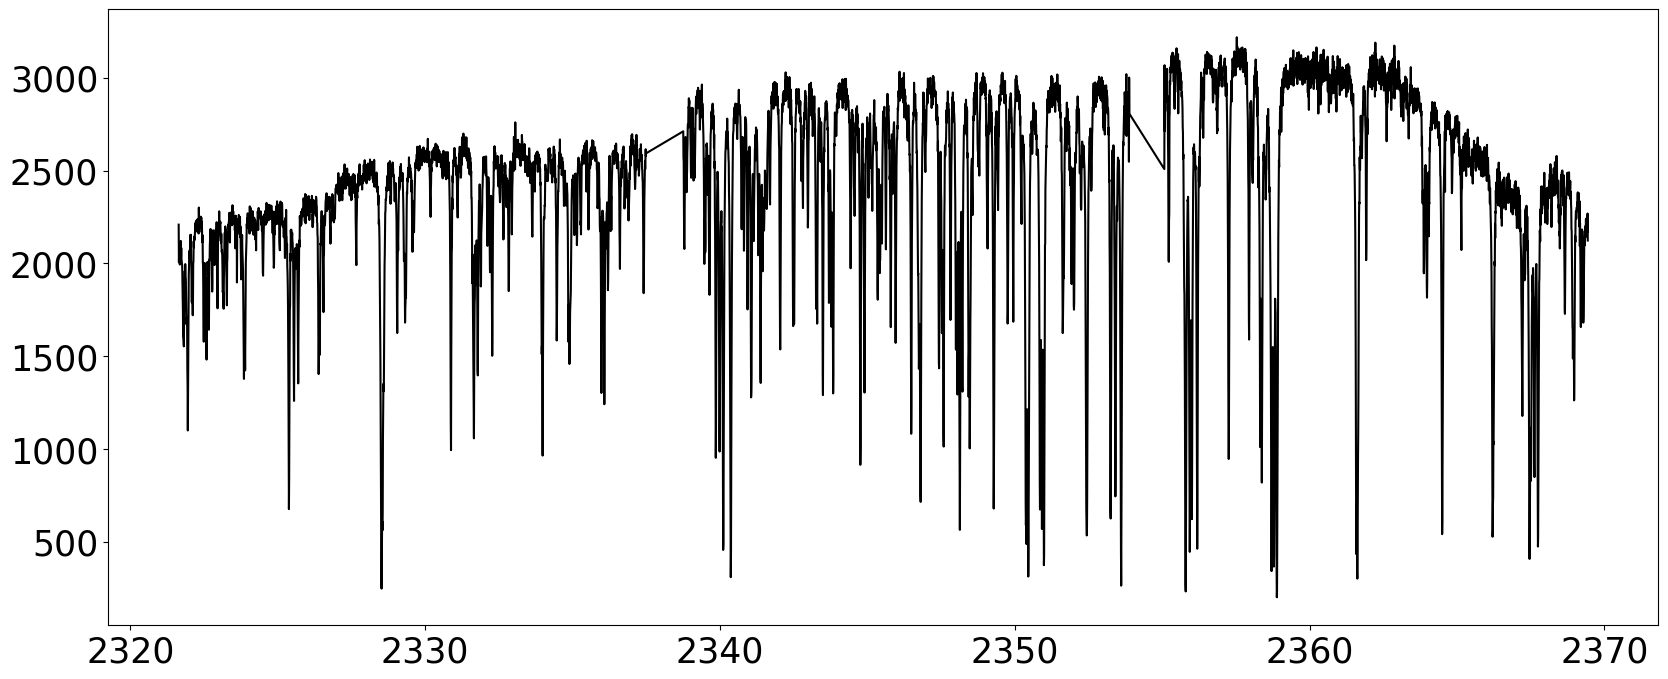

In [28]:
wave = []
flux = []

i = 1
wave.extend(frame_WL[frame][i][7:-8])
flux.extend(np.array(frame_spec[frame][i][7:-8]))
i = 7
wave.extend(frame_WL[frame][i][8:-9])
flux.extend(frame_spec[frame][i][8:-9])
i = 13
wave.extend(frame_WL[frame][i][9:-10])
flux.extend(frame_spec[frame][i][9:-10])

print(len(wave))

wave = np.array(wave)
flux = np.array(flux)

plt.plot(wave,flux,'k')

[ 1.28720552e-18 -1.24875031e-15 -2.33628962e-11 -2.74599145e-09
  3.42321109e-05  1.41784909e-01  2.94592869e+03]


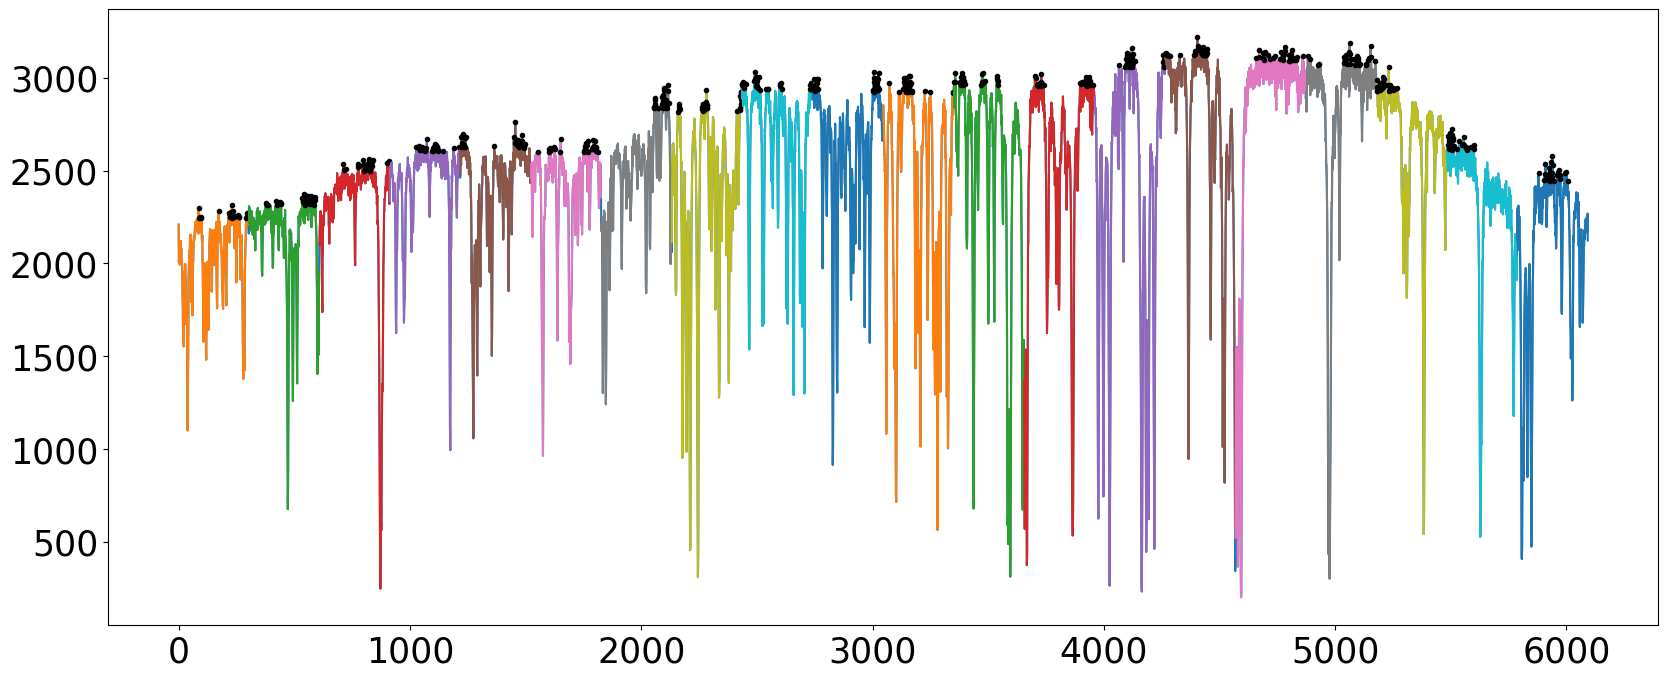

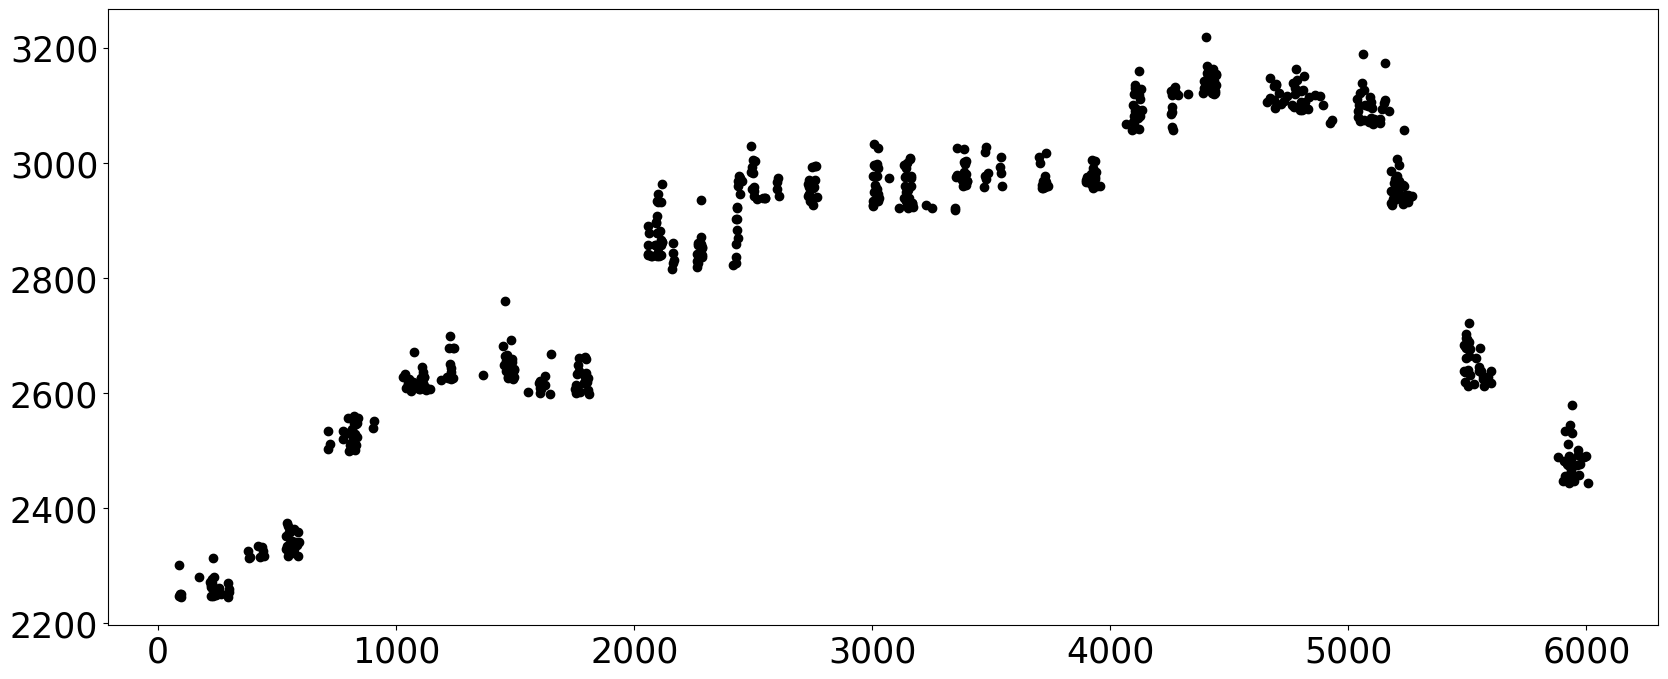

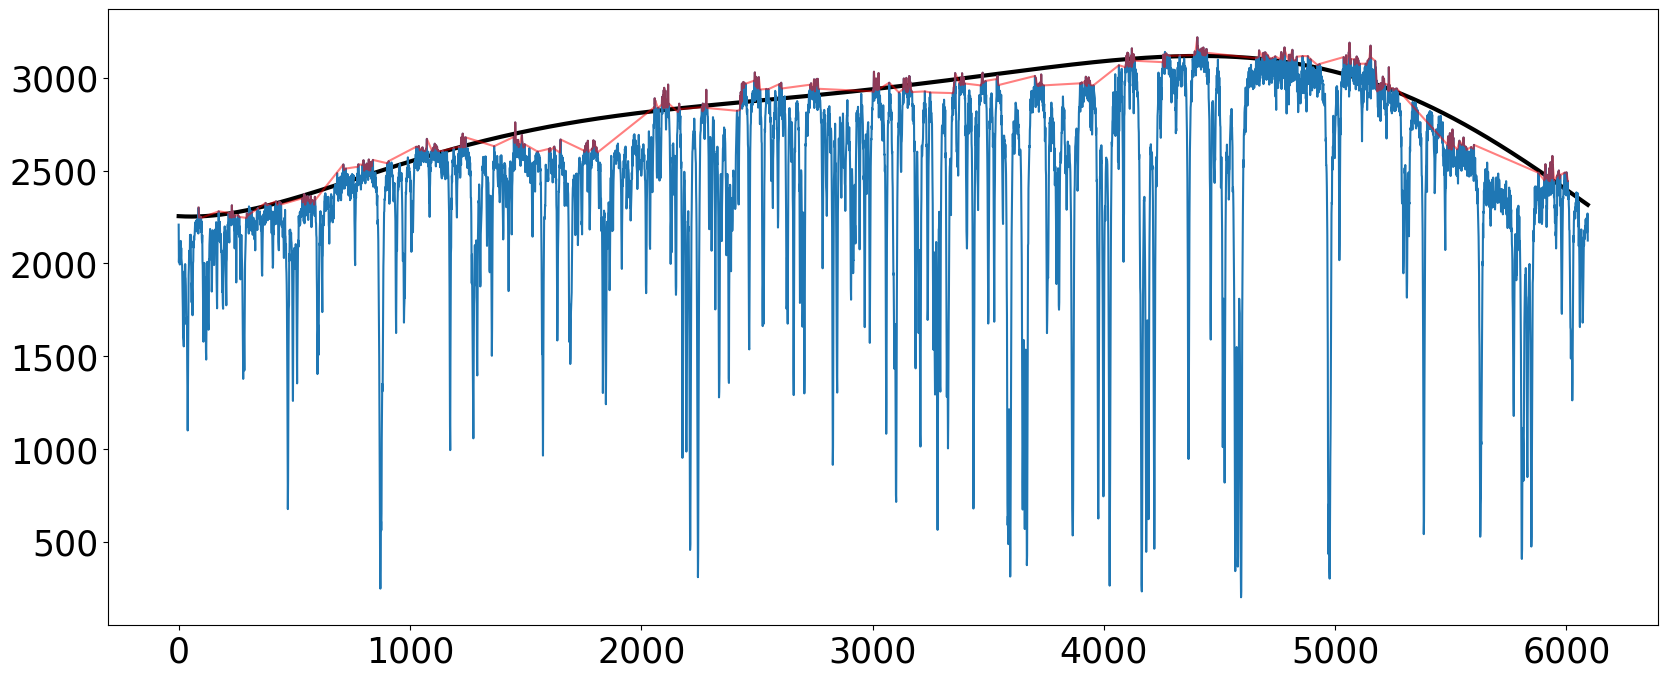

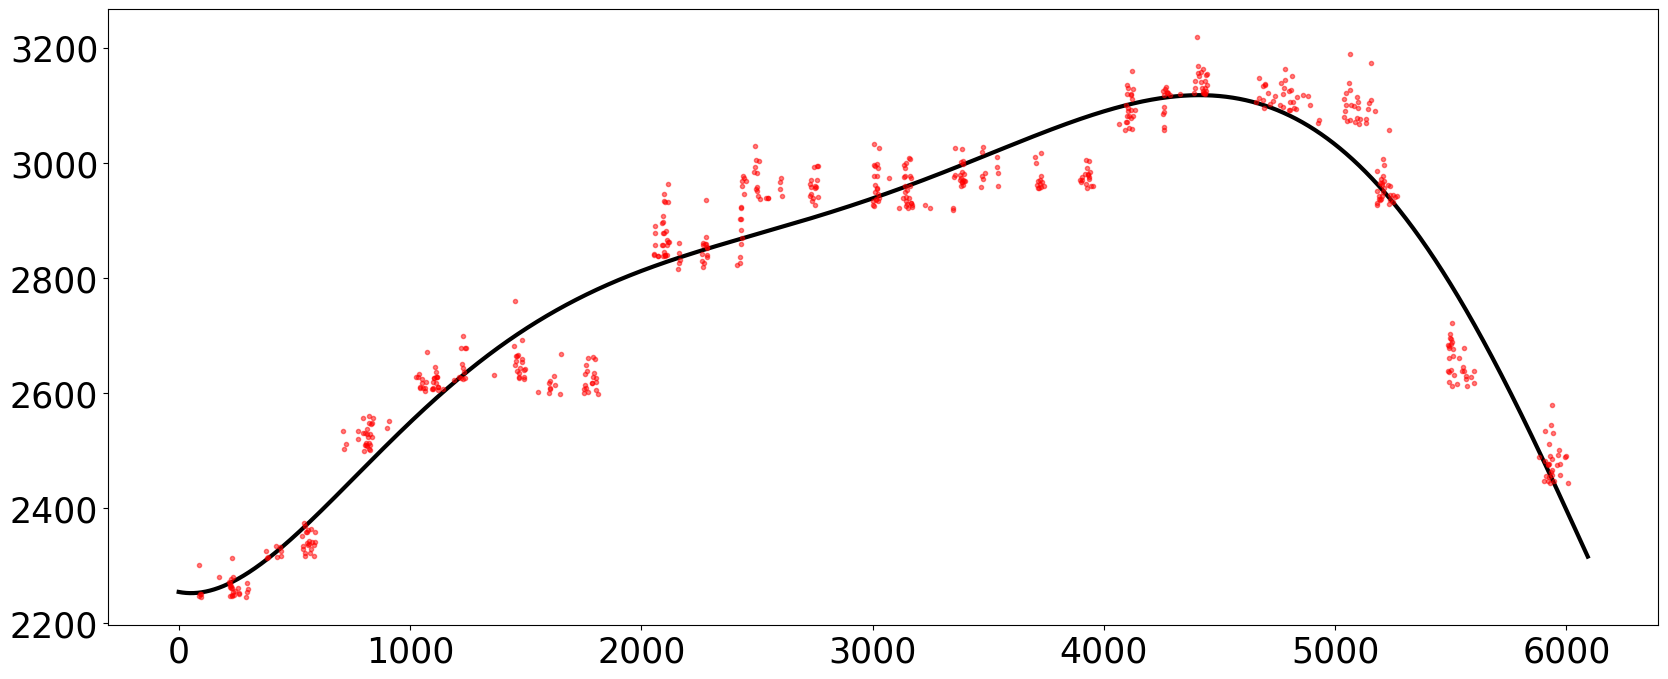

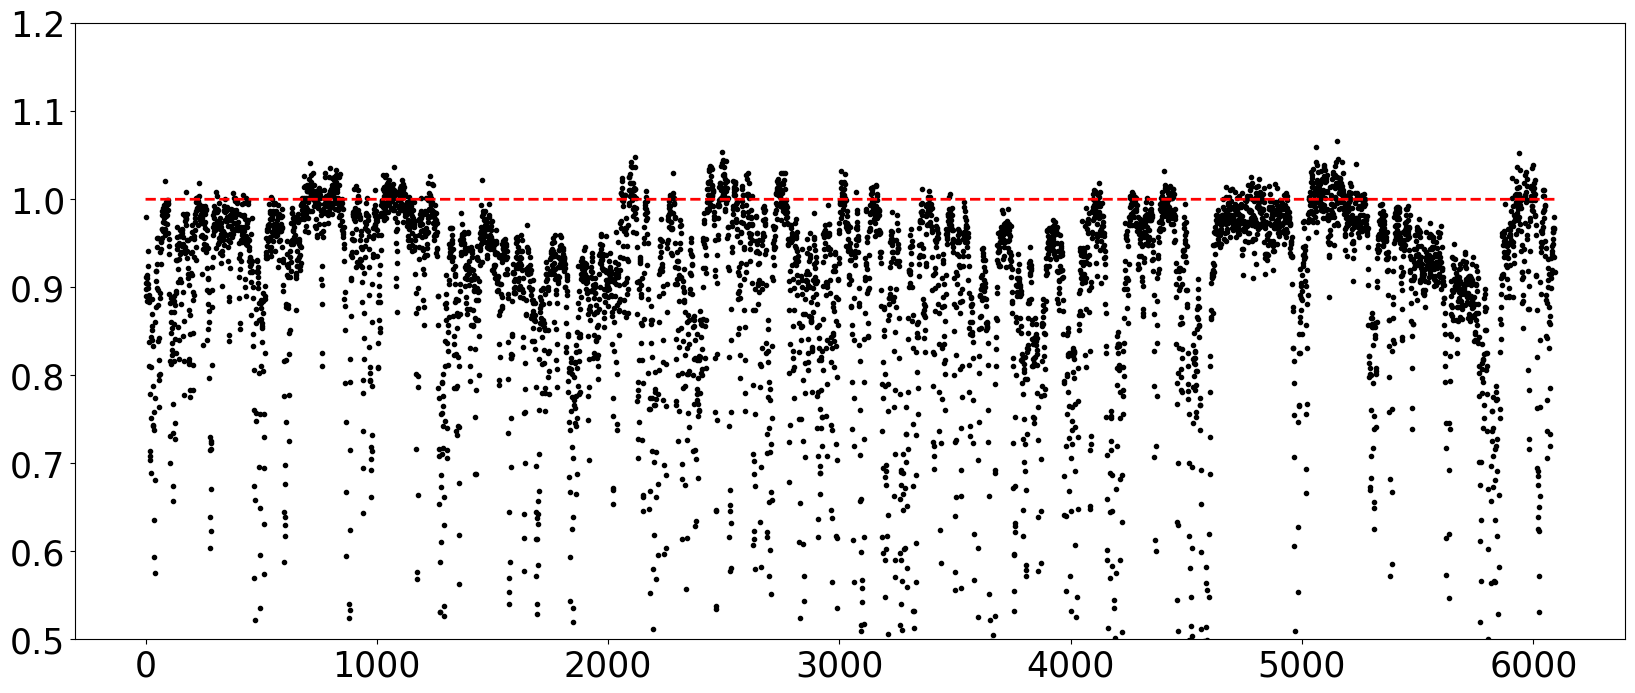

In [29]:
bins = 20
p_order = 6
fraction = 0.1
plot = True
wave_n, flux_n = Normalization(wave, flux, bins, p_order, fraction, plot, section=0)

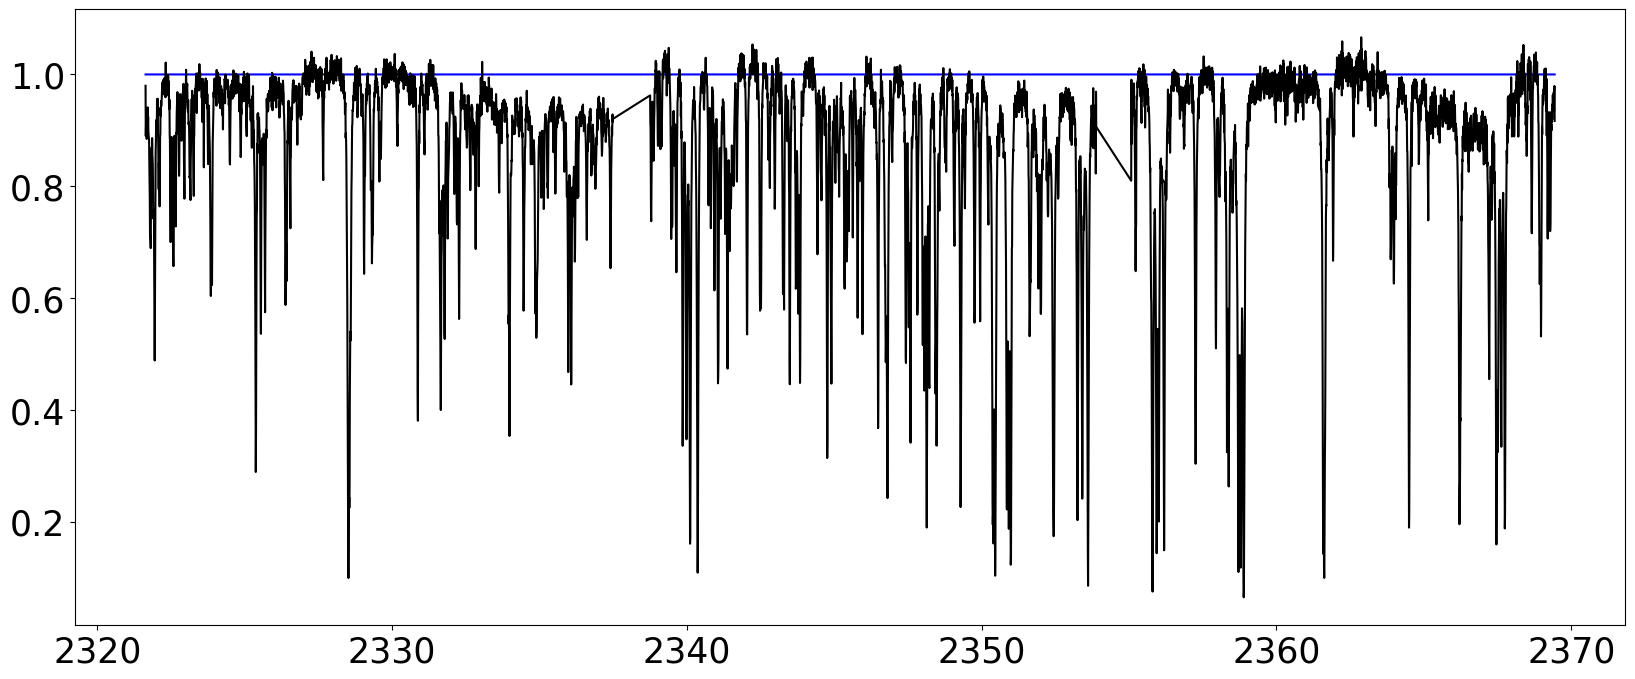

In [30]:
plt.plot(wave, np.ones_like(wave), 'b')
plt.plot(wave_n ,flux_n,'k')
full_wave_n.extend(wave_n)
full_flux_n.extend(flux_n)

# Testing Normalization part 7

6060


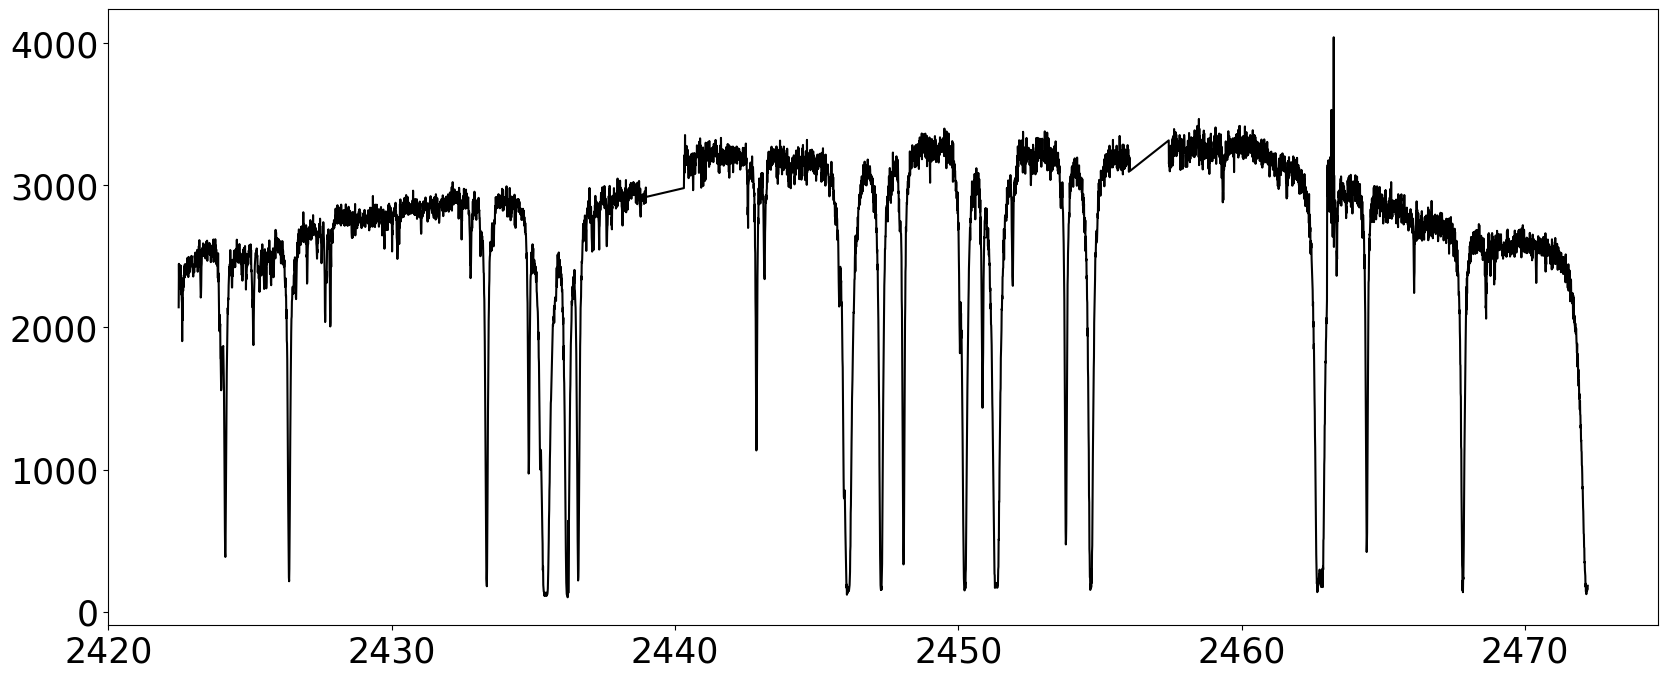

In [31]:
wave = []
flux = []

i = 0
wave.extend(frame_WL[frame][i][9:-10])
flux.extend(np.array(frame_spec[frame][i][9:-10]))
i = 6
wave.extend(frame_WL[frame][i][10:-11])
flux.extend(frame_spec[frame][i][10:-11])
i = 12
wave.extend(frame_WL[frame][i][22:-22])
flux.extend(frame_spec[frame][i][22:-22])

print(len(wave))

wave = np.array(wave)
flux = np.array(flux)

plt.plot(wave,flux,'k')

[ 1.95393627e-18  2.93678221e-15 -2.34044018e-11 -4.19140421e-08
 -2.00234767e-05  1.48405338e-01  3.26942451e+03]


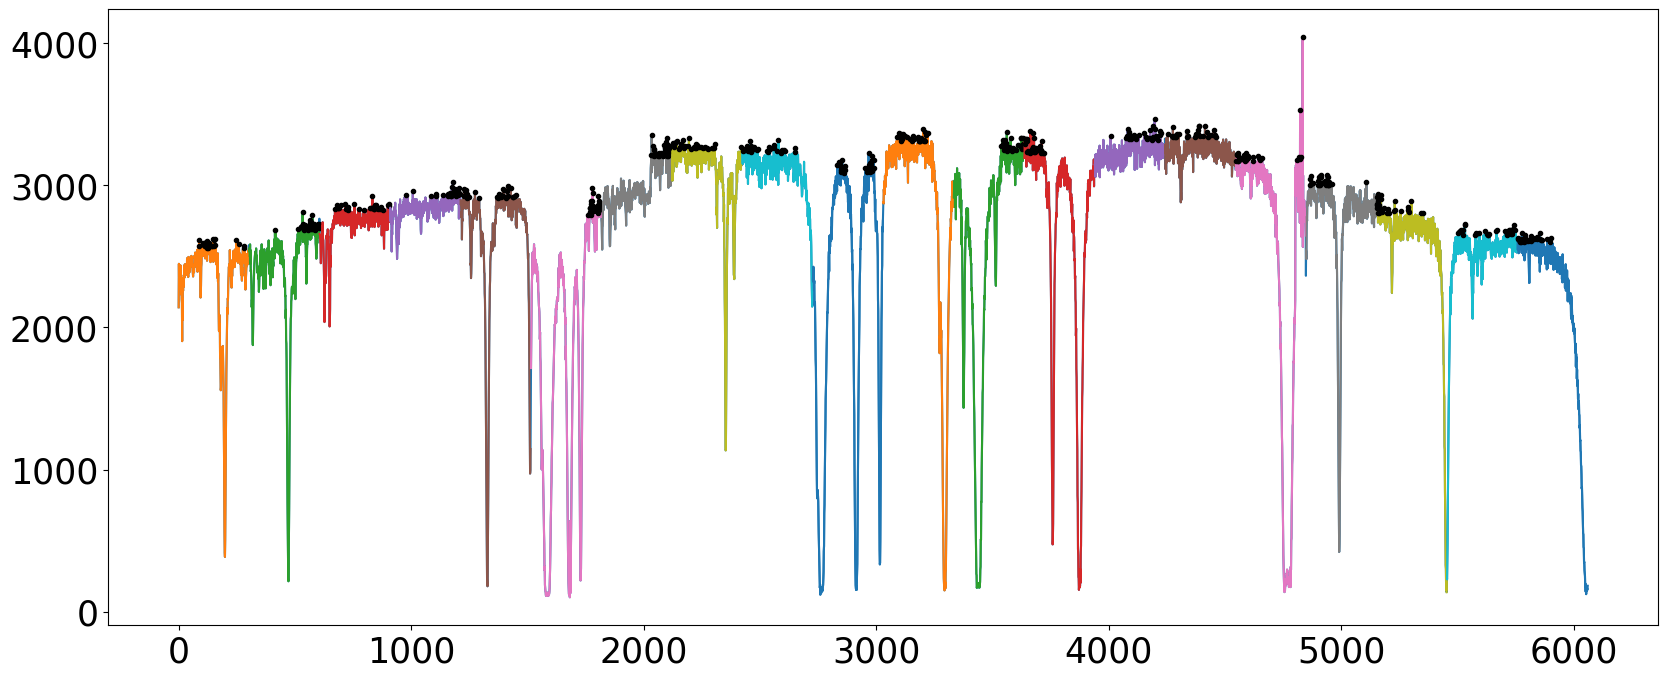

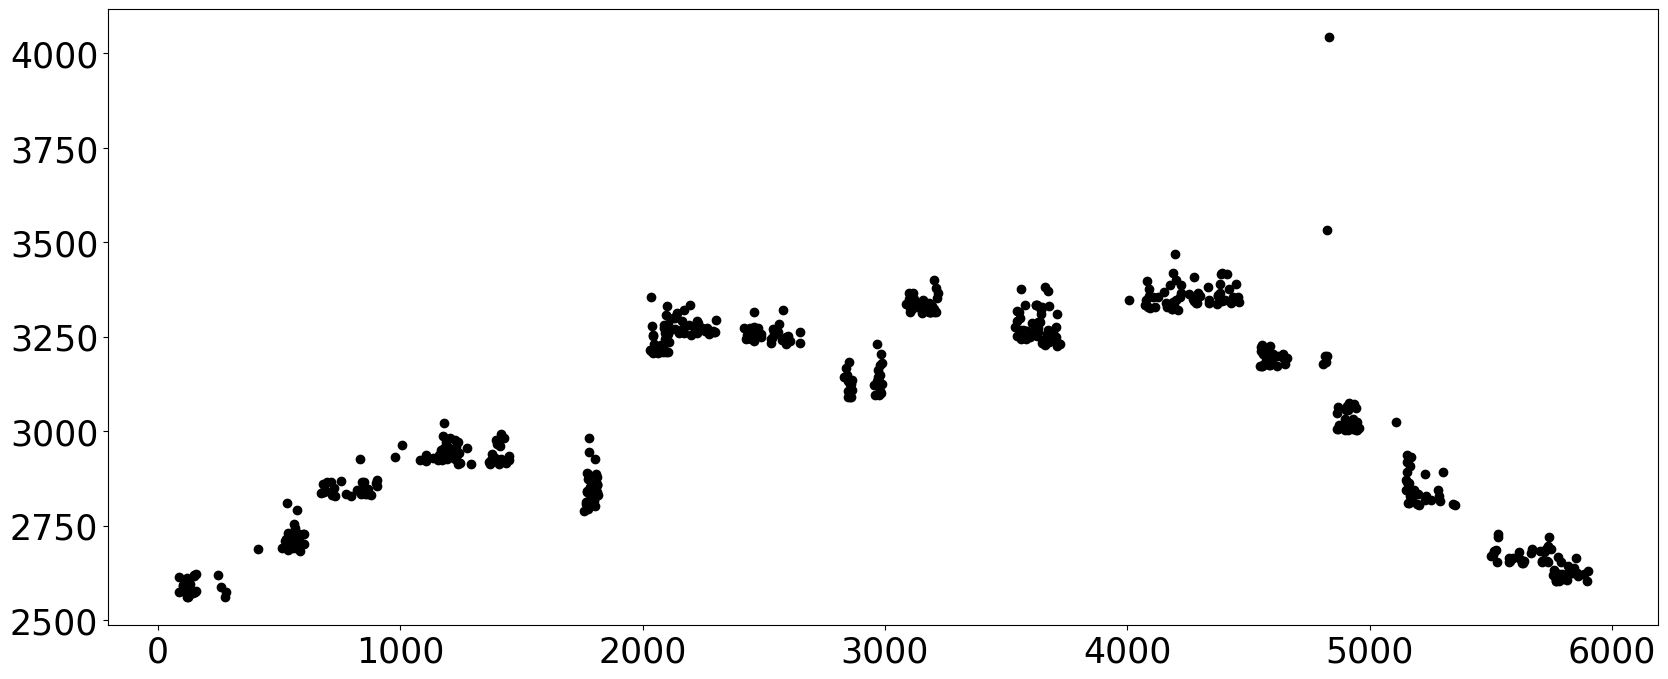

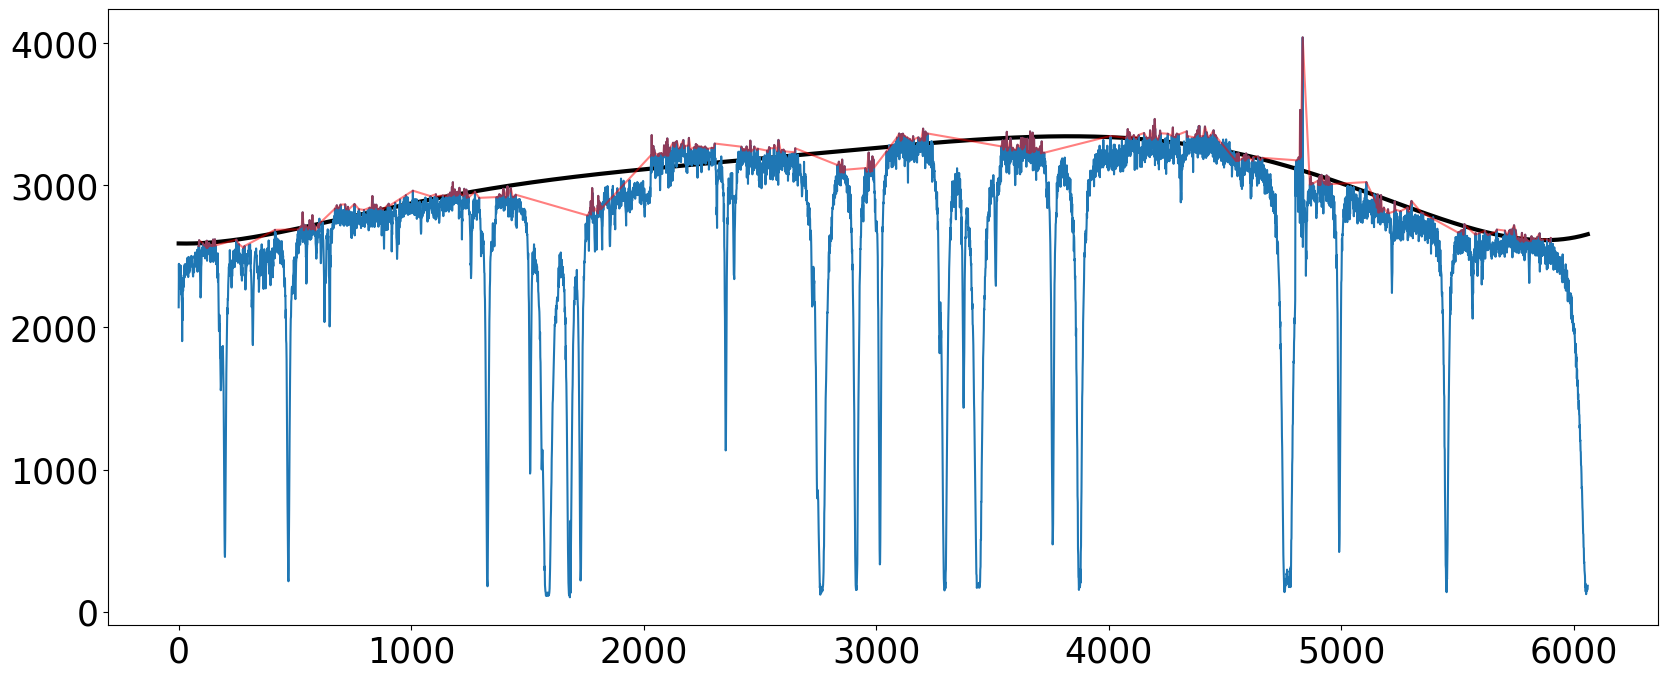

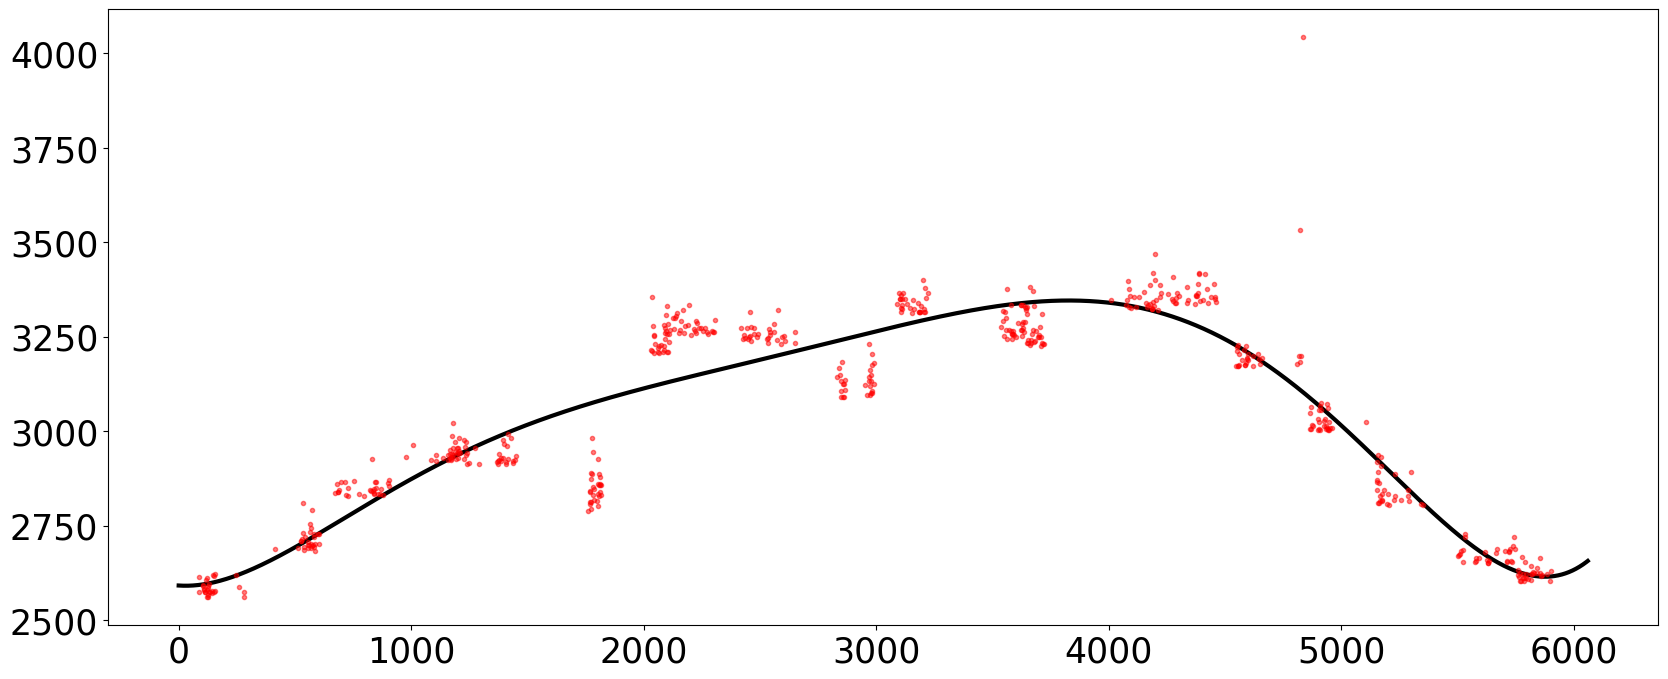

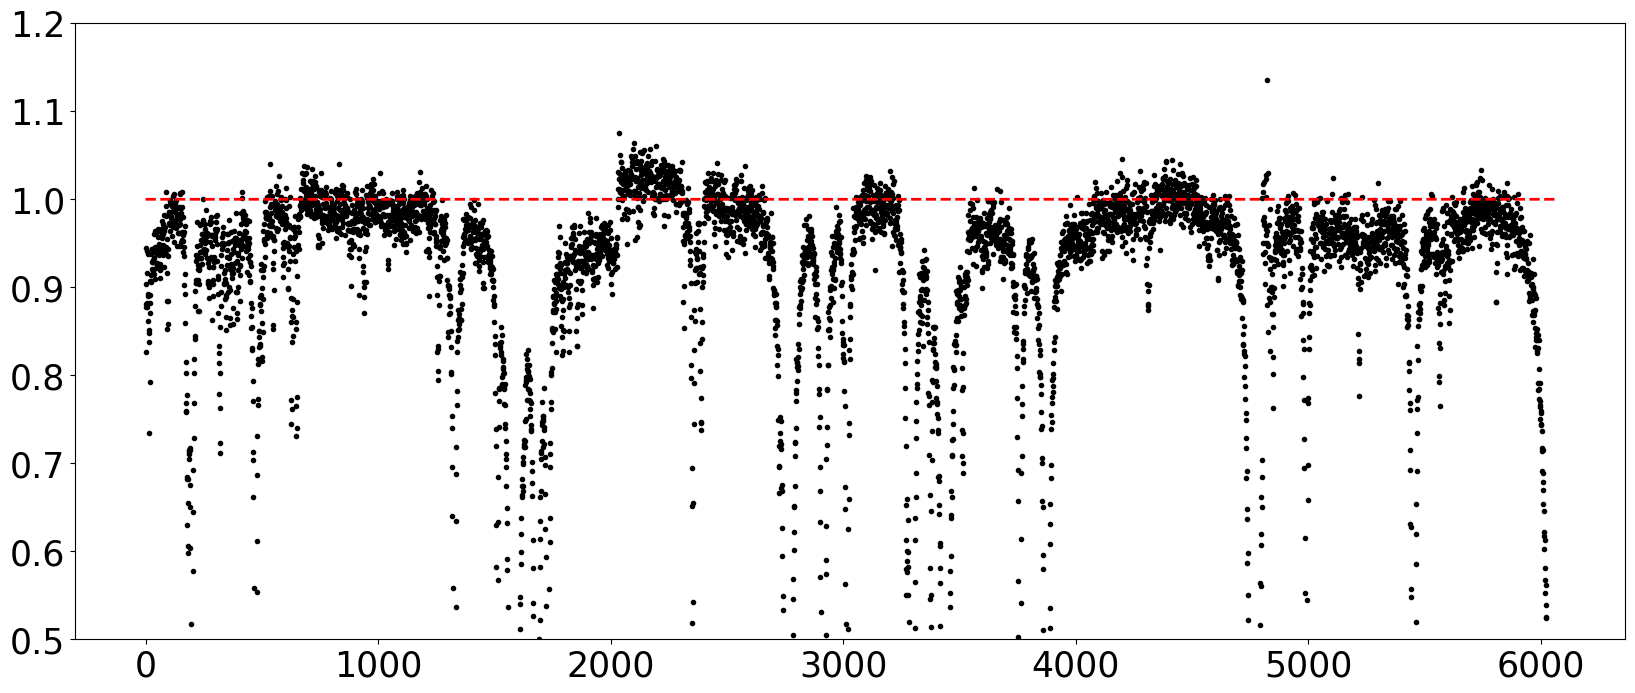

In [32]:
bins = 20
p_order = 6
fraction = 0.1
plot = True
wave_n, flux_n = Normalization(wave, flux, bins, p_order, fraction, plot, section=0)

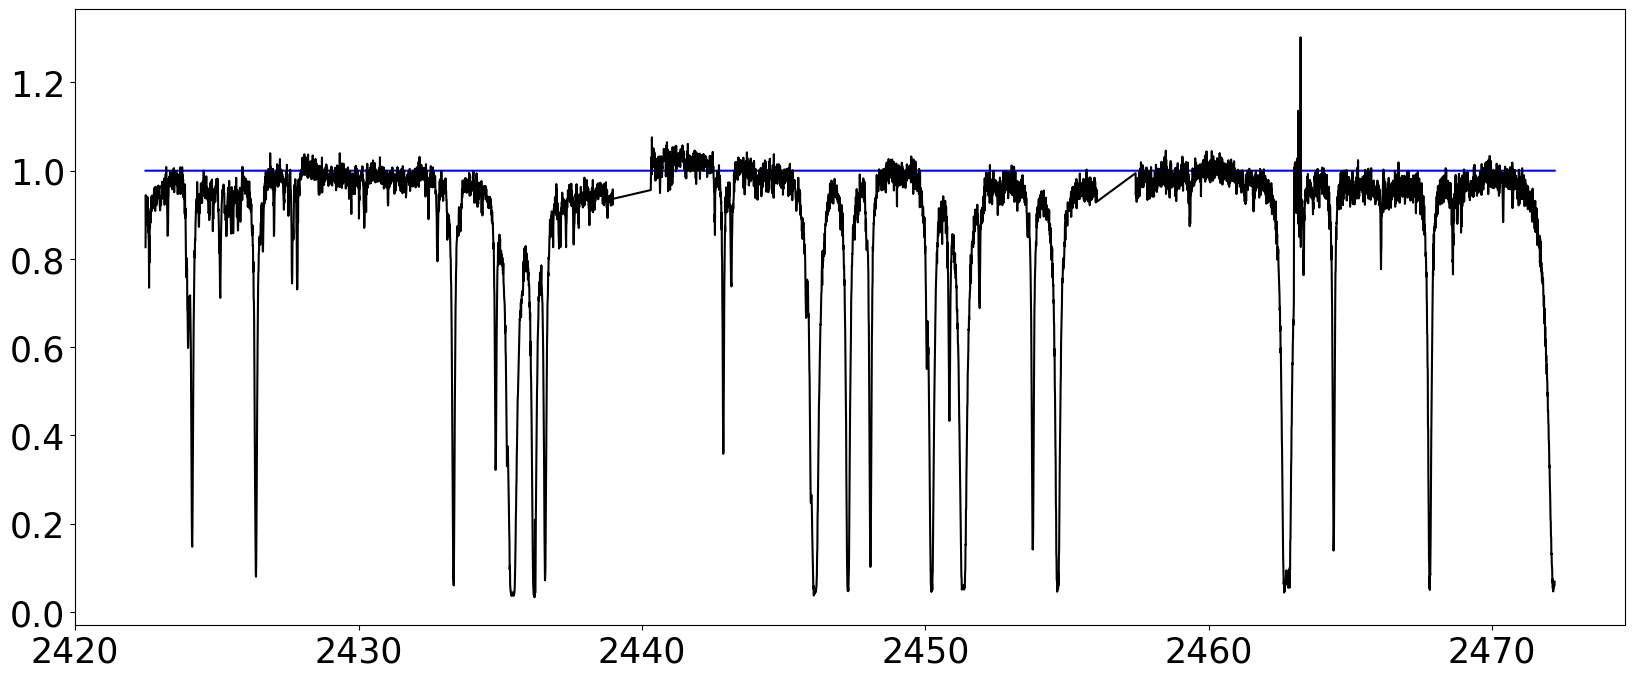

In [33]:
plt.plot(wave, np.ones_like(wave), 'b')
plt.plot(wave_n ,flux_n,'k')
full_wave_n.extend(wave_n)
full_flux_n.extend(flux_n)

In [34]:
full_wave_n = np.array(full_wave_n)
full_flux_n = np.array(full_flux_n)

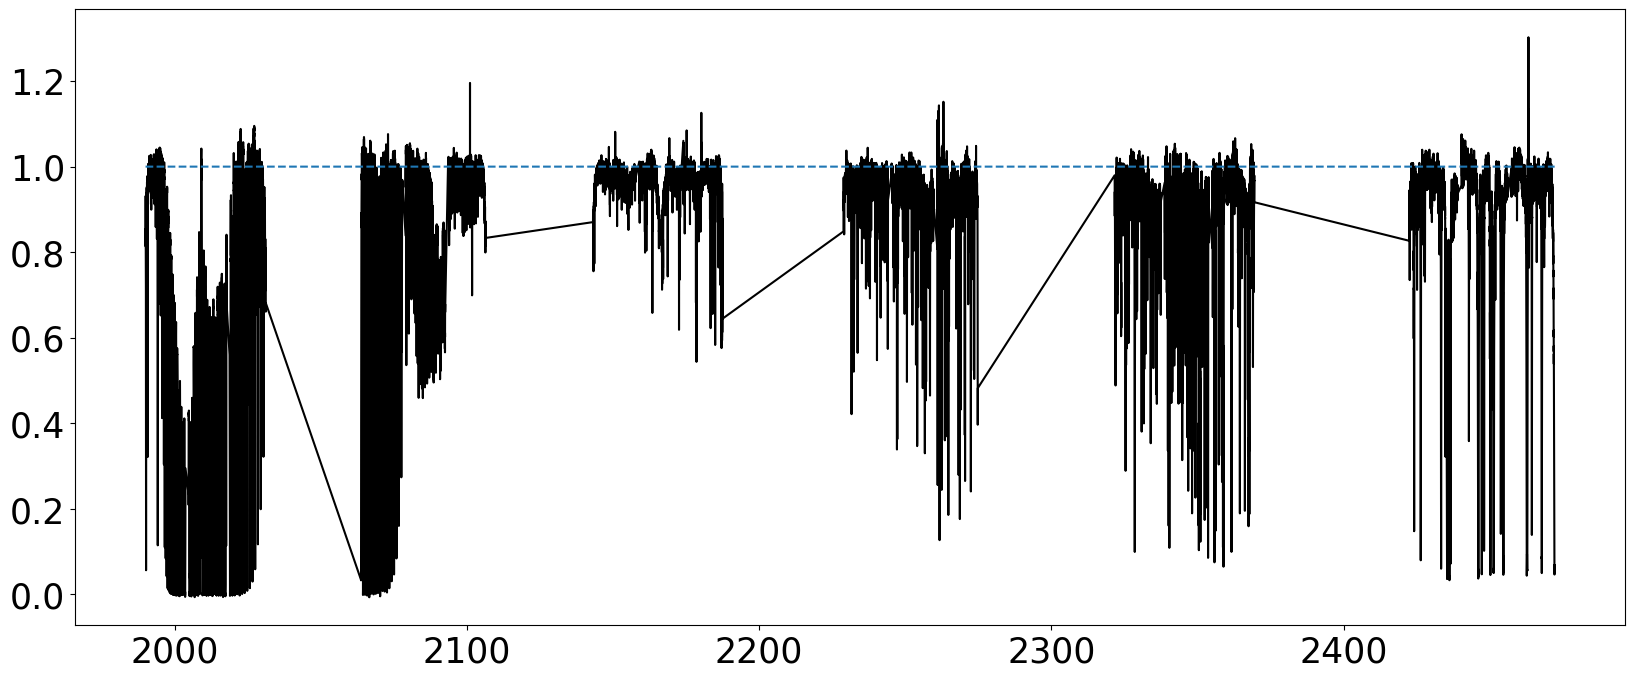

In [35]:
plt.plot(full_wave_n, full_flux_n, 'k')
plt.plot(full_wave_n, np.ones_like(full_wave_n), '--')